In [1]:
!pip install aim torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 60.1 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 97.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 67.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.1 MB/s eta 0:00:00
  Created wheel for aim-ui: filename=aim_ui-3.28.0-py3-none-any.whl size=31194921 sha256=43f456fa640cdbfe321d32f0b34cedd08dd3ef5b552aa77616355649a0fa5e51
  Stored in directory: /root/.cache/pip/wheels/b8/19/9d/f27f361c0ed65f9d2c0030fda1e7f017ae56b335f81576a1dd
Successfully built aim-ui


In [77]:
from dataclasses import dataclass
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

import torch
from torch import nn, Tensor
from torch.nn import BCEWithLogitsLoss
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader
from torchmetrics import MeanMetric, AUROC

from aim import Run
from tqdm import tqdm

In [3]:
train_data, test_data = pd.read_csv('/kaggle/input/loan-approval-prediction/loan_train.csv'), pd.read_csv('/kaggle/input/loan-approval-prediction/loan_test.csv')

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52780 entries, 0 to 52779
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          52780 non-null  int64  
 1   person_age                  52780 non-null  int64  
 2   person_income               52780 non-null  int64  
 3   person_home_ownership       52780 non-null  object 
 4   person_emp_length           52780 non-null  float64
 5   loan_intent                 52780 non-null  object 
 6   loan_grade                  52780 non-null  object 
 7   loan_amnt                   52780 non-null  int64  
 8   loan_int_rate               52780 non-null  float64
 9   loan_percent_income         52780 non-null  float64
 10  cb_person_default_on_file   52780 non-null  object 
 11  cb_person_cred_hist_length  52780 non-null  int64  
 12  loan_status                 52780 non-null  int64  
dtypes: float64(3), int64(6), object

In [5]:
train_data.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,52780.000000,52780.000000,5.278000e+04,52780.000000,52780.000000,52780.000000,52780.000000,52780.000000,52780.000000
mean,29323.588291,27.554926,6.396906e+04,4.696192,9210.809530,10.678262,0.159226,5.815517,0.142383
std,16936.066613,6.046298,3.611165e+04,3.966526,5560.086455,3.038162,0.091758,4.037774,0.349446
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14669.750000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,44002.250000,30.000000,7.540000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.200000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [6]:
display(train_data.head())
display(test_data.head())

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,42788,21,102000,MORTGAGE,5.0,EDUCATION,A,10000,7.51,0.10,N,4,0
1,11553,23,49000,RENT,1.0,HOMEIMPROVEMENT,D,5000,13.17,0.10,Y,4,1
2,27481,23,30000,RENT,1.0,MEDICAL,B,10000,11.99,0.33,N,4,1
3,39841,32,95000,MORTGAGE,9.0,HOMEIMPROVEMENT,C,15000,12.84,0.16,Y,5,0
4,55662,31,32000,MORTGAGE,3.0,HOMEIMPROVEMENT,A,1200,7.68,0.04,N,10,0


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,35352,39,60000,MORTGAGE,5.0,EDUCATION,A,12000,7.88,0.20,N,12,0
1,5114,25,65000,MORTGAGE,9.0,EDUCATION,B,7000,12.42,0.11,N,4,0
2,33050,22,72000,MORTGAGE,6.0,PERSONAL,D,2000,14.84,0.03,N,2,0
3,14668,23,24000,RENT,3.0,DEBTCONSOLIDATION,B,8000,10.99,0.33,N,2,1
4,298,31,56000,RENT,1.0,MEDICAL,B,2500,11.49,0.04,N,9,0


In [7]:
categorical_features = train_data.select_dtypes('object')

for feature in categorical_features:
    print(feature)
    print(sorted(train_data[feature].unique()))
    print(sorted(test_data[feature].unique()), end='\n\n')

person_home_ownership
['MORTGAGE', 'OTHER', 'OWN', 'RENT']
['MORTGAGE', 'OTHER', 'OWN', 'RENT']

loan_intent
['DEBTCONSOLIDATION', 'EDUCATION', 'HOMEIMPROVEMENT', 'MEDICAL', 'PERSONAL', 'VENTURE']
['DEBTCONSOLIDATION', 'EDUCATION', 'HOMEIMPROVEMENT', 'MEDICAL', 'PERSONAL', 'VENTURE']

loan_grade
['A', 'B', 'C', 'D', 'E', 'F', 'G']
['A', 'B', 'C', 'D', 'E', 'F', 'G']

cb_person_default_on_file
['N', 'Y']
['N', 'Y']



In [8]:
categories = {
    'person_home_ownership' : {
        'MORTGAGE' : 0,
        'RENT'     : 1,
        'OWN'      : 2,
        'OTHER'    : 3
    },
    'loan_intent' : {
        'EDUCATION'         : 0,
        'HOMEIMPROVEMENT'   : 1,
        'MEDICAL'           : 2,
        'DEBTCONSOLIDATION' : 3,
        'VENTURE'           : 4,
        'PERSONAL'          : 5
    },
    'loan_grade' : {
        'A' : 0,
        'B' : 1,
        'C' : 2,
        'D' : 3,
        'E' : 4,
        'F' : 5,
        'G' : 6
    },
    'cb_person_default_on_file' : {
        'N' : 0,
        'Y' : 1
    }
}

In [9]:
print(train_data.isna().sum(), test_data.isna().sum(), sep='\n\n')

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64


In [10]:
for col in train_data.select_dtypes('number'):
    print(f'{col}: max - {max(train_data[col].max(), test_data[col].max())}, min - {min(train_data[col].min(), test_data[col].min())}')

id: max - 58644, min - 0
person_age: max - 123, min - 20
person_income: max - 1900000, min - 4200
person_emp_length: max - 123.0, min - 0.0
loan_amnt: max - 35000, min - 500
loan_int_rate: max - 23.22, min - 5.42
loan_percent_income: max - 0.83, min - 0.0
cb_person_cred_hist_length: max - 30, min - 2
loan_status: max - 1, min - 0


In [11]:
class LoanDataset(Dataset):
    def __init__(self, data: pd.DataFrame):
        data = data.reset_index(drop=True)
        self._data = data

    def __len__(self):
        return len(self._data)

    def __getitem__(self, item: int) -> dict[str, dict[str | Tensor] | Tensor]:
        item = self._data.iloc[item]
        return {
            'target': torch.scalar_tensor(item['loan_status'], dtype=torch.float32),
            'cat_features': {
                'home'   : torch.scalar_tensor(categories['person_home_ownership'][item['person_home_ownership']], dtype=torch.long),
                'intent': torch.scalar_tensor(categories['loan_intent'][item['loan_intent']], dtype=torch.long),
                'grade' : torch.scalar_tensor(categories['loan_grade'][item['loan_grade']], dtype=torch.long),
                'cpdof' : torch.scalar_tensor(categories['cb_person_default_on_file'][item['cb_person_default_on_file']], dtype=torch.long)
            },
            'numeric_features': {
                'age': torch.scalar_tensor(item['person_age'] / 123, dtype=torch.float32),
                'income': torch.scalar_tensor(item['person_income'] / 1900000, dtype=torch.float32),
                'emp': torch.scalar_tensor(item['person_emp_length'] / 123, dtype=torch.float32),
                'amnt': torch.scalar_tensor(item['loan_amnt'] / 35000, dtype=torch.float32),
                'rate': torch.scalar_tensor(item['loan_int_rate'] / 24, dtype=torch.float32),
                'p_income': torch.scalar_tensor(item['loan_percent_income'], dtype=torch.float32),  # Changed to match collator
                'cred_hist': torch.scalar_tensor(item['cb_person_cred_hist_length'] / 30, dtype=torch.float32),
            }
        }


In [12]:
class LoanCollator:
    def __call__(self, items: list[dict[str, dict[str | Tensor] | Tensor]]) -> dict[str, dict[str | Tensor] | Tensor]:
        return {
            'target': torch.stack([x['target'] for x in items]),
            'cat_features': {
                'home'   : torch.stack([x['cat_features']['home'] for x in items]),
                'intent': torch.stack([x['cat_features']['intent'] for x in items]),
                'grade' : torch.stack([x['cat_features']['grade'] for x in items]),
                'cpdof' : torch.stack([x['cat_features']['cpdof'] for x in items])
            },
            'numeric_features': {
                'age'    : torch.stack([x['numeric_features']['age'] for x in items]),
                'income' : torch.stack([x['numeric_features']['income'] for x in items]),
                'emp'    : torch.stack([x['numeric_features']['emp'] for x in items]),
                'amnt'   : torch.stack([x['numeric_features']['amnt'] for x in items]),
                'rate'   : torch.stack([x['numeric_features']['rate'] for x in items]),
                'p_income': torch.stack([x['numeric_features']['p_income'] for x in items]),
                'cred_hist'  : torch.stack([x['numeric_features']['cred_hist'] for x in items])
            }
        }
        

In [13]:
train_dataset, test_dataset = LoanDataset(train_data), LoanDataset(test_data)

In [14]:
def map_to_device(batch: dict, dev: torch.device) -> dict:
    batch['target'] = batch['target'].to(dev)

    for (name, feature) in batch['cat_features'].items():
        batch['cat_features'][name] = feature.to(dev)

    for (name, feature) in batch['numeric_features'].items():
        batch['numeric_features'][name] = feature.to(dev)

In [15]:
@dataclass
class Config:
    experiment_name: str
    seed: int
    batch_size: int
    hidden_size: int
    lr: float
    num_epochs: int
    weight_decay: float = 0
    drop_p: float = None

In [22]:
def plot_metrics(train_losses, eval_losses, train_rocauc_values, eval_rocauc_values):
    epoch_steps = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 6))

    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(epoch_steps, train_losses, label='Train Loss', color='blue', marker='o', markersize=4)
    plt.plot(epoch_steps, eval_losses, label='Eval Loss', color='red', marker='x', markersize=4)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.grid(True)
    plt.legend()

    for i in range(0, len(epoch_steps), 5):
        plt.text(epoch_steps[i], train_losses[i], f'{train_losses[i]:.2f}', fontsize=9, color='blue')
        plt.text(epoch_steps[i], eval_losses[i], f'{eval_losses[i]:.2f}', fontsize=9, color='red')

    # График ROC-AUC
    plt.subplot(1, 2, 2)
    plt.plot(epoch_steps, train_rocauc_values, label='Train ROC-AUC', color='blue', marker='o', markersize=4)
    plt.plot(epoch_steps, eval_rocauc_values, label='Eval ROC-AUC', color='red', marker='x', markersize=4)
    plt.xlabel('Epoch')
    plt.ylabel('ROC-AUC')
    plt.title('ROC-AUC vs Epoch')
    plt.grid(True)
    plt.legend()

    for i in range(0, len(epoch_steps), 5):
        plt.text(epoch_steps[i], train_rocauc_values[i], f'{train_rocauc_values[i]:.2f}', fontsize=9, color='blue')
        plt.text(epoch_steps[i], eval_rocauc_values[i], f'{eval_rocauc_values[i]:.2f}', fontsize=9, color='red')

    plt.tight_layout()
    plt.show()

In [65]:
def train(config, model, train_data, eval_data):
    dev = 'cuda' if torch.cuda.is_available() else 'cpu'
    torch.random.manual_seed(config.seed)
    
    loss_bce = BCEWithLogitsLoss()
    collator = LoanCollator()
    model = model(config).to(dev)
    optimizer = SGD(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    
    run = Run(experiment=config.experiment_name)
    run["hparams"] = {
        "learning_rate": config.lr,
        "base_hidden_size": config.hidden_size,
        "batch_size": config.batch_size,
        'weight_decay': config.weight_decay
    }
    
    train_dl = DataLoader(train_data, batch_size=config.batch_size, collate_fn=collator)
    eval_dl = DataLoader(eval_data, batch_size=config.batch_size, collate_fn=collator)
    
    train_losses, eval_losses = [], []
    train_rocaucs, eval_rocaucs = [], []
    
    for i_epoch in tqdm(range(config.num_epochs)):
        train_loss = MeanMetric().to(dev)
        train_rocauc = AUROC(task='binary').to(dev)
        
        for batch in train_dl:
            map_to_device(batch, dev)
            result = model(cat_features=batch['cat_features'], numeric_features=batch['numeric_features'])
            loss_value = loss_bce(result, batch['target'])
            loss_value.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss.update(loss_value)
            train_rocauc.update(torch.sigmoid(result), batch['target'])
        
        train_loss_value = train_loss.compute().item()
        train_rocauc_value = train_rocauc.compute().item()
        train_losses.append(train_loss_value)
        train_rocaucs.append(train_rocauc_value)
        run.track(train_loss_value, name='loss/train', step=i_epoch)
        run.track(train_rocauc_value, name='roc-auc/train', step=i_epoch)
        
        eval_loss = MeanMetric().to(dev)
        eval_rocauc = AUROC(task='binary').to(dev)
        
        model.eval()
        with torch.no_grad():
            for batch_eval in eval_dl:
                map_to_device(batch_eval, dev)
                result_eval = model(cat_features=batch_eval['cat_features'], numeric_features=batch_eval['numeric_features'])
                eval_loss_value = loss_bce(result_eval, batch_eval['target'])
                eval_loss.update(eval_loss_value)
                eval_rocauc.update(torch.sigmoid(result_eval), batch_eval['target'])
        model.train()
        
        eval_loss_value = eval_loss.compute().item()
        eval_rocauc_value = eval_rocauc.compute().item()
        eval_losses.append(eval_loss_value)
        eval_rocaucs.append(eval_rocauc_value)
        run.track(eval_loss_value, name='loss/eval', step=i_epoch)
        run.track(eval_rocauc_value, name='roc-auc/eval', step=i_epoch)
        
        print(f"Epoch {i_epoch+1}/{config.num_epochs}: Train Loss={train_loss_value:.4f}, Train ROC-AUC={train_rocauc_value:.4f}, Eval Loss={eval_loss_value:.4f}, Eval ROC-AUC={eval_rocauc_value:.4f}")
    
    plot_metrics(train_losses, eval_losses, train_rocaucs, eval_rocaucs)

# **Эксперимент 1. Базовая модель**

In [33]:
base_config = Config(experiment_name='BaseModel',
                     batch_size=32, 
                     hidden_size=32, 
                     lr=0.01, 
                     num_epochs=10, 
                     seed=42)

In [34]:
class BaseBlock(nn.Module):
    def __init__(self, hidden_size: int):
        super().__init__()
        self.linear_1 = nn.Linear(hidden_size, hidden_size * 4)
        self.act = nn.LeakyReLU()
        self.linear_2 = nn.Linear(hidden_size * 4, hidden_size)

    def forward(self, x: Tensor) -> Tensor:
        x = self.linear_1(x)
        x = self.act(x)
        x = self.linear_2(x)
        return x 


class BaseModel(nn.Module):
    def __init__(
            self,
           config: Config,
    ):
        super().__init__()

        self.emb_home = nn.Embedding(4, config.hidden_size)
        self.emb_intent = nn.Embedding(6, config.hidden_size)
        self.emb_grade = nn.Embedding(7, config.hidden_size)
        self.emb_default = nn.Embedding(2, config.hidden_size)

        self.numeric_proj = nn.Linear(7, config.hidden_size)
        self.blocks = nn.Sequential(
            *[BaseBlock(config.hidden_size) for _ in range(1)]
        )

        self.output = nn.Linear(config.hidden_size, 1)

    def forward(
            self,
            cat_features: dict[str, Tensor],
            numeric_features: dict[str, Tensor]
    ) -> Tensor:
        x_home = self.emb_home(cat_features['home'])
        x_intent = self.emb_intent(cat_features['intent'])
        x_grade = self.emb_grade(cat_features['grade'])
        x_default = self.emb_default(cat_features['cpdof'])

        numeric_stack = torch.stack([
            numeric_features['age'],
            numeric_features['income'],
            numeric_features['emp'],
            numeric_features['amnt'],
            numeric_features['rate'],
            numeric_features['p_income'],
            numeric_features['cred_hist']
        ], dim=-1)

        x_numeric = self.numeric_proj(numeric_stack)
        x = x_home + x_intent + x_grade + x_default + x_numeric
        x = self.blocks(x)

        return self.output(x).squeeze(-1)

 10%|█         | 1/10 [00:12<01:51, 12.38s/it]

Epoch 1/10: Train Loss=0.3164, Train ROC-AUC=0.8143, Eval Loss=0.2892, Eval ROC-AUC=0.8530


 20%|██        | 2/10 [00:24<01:39, 12.41s/it]

Epoch 2/10: Train Loss=0.2870, Train ROC-AUC=0.8498, Eval Loss=0.2777, Eval ROC-AUC=0.8691


 30%|███       | 3/10 [00:37<01:26, 12.42s/it]

Epoch 3/10: Train Loss=0.2770, Train ROC-AUC=0.8638, Eval Loss=0.2691, Eval ROC-AUC=0.8827


 40%|████      | 4/10 [00:49<01:14, 12.46s/it]

Epoch 4/10: Train Loss=0.2673, Train ROC-AUC=0.8770, Eval Loss=0.2597, Eval ROC-AUC=0.8937


 50%|█████     | 5/10 [01:02<01:02, 12.53s/it]

Epoch 5/10: Train Loss=0.2579, Train ROC-AUC=0.8862, Eval Loss=0.2502, Eval ROC-AUC=0.8999


 60%|██████    | 6/10 [01:14<00:49, 12.49s/it]

Epoch 6/10: Train Loss=0.2496, Train ROC-AUC=0.8915, Eval Loss=0.2417, Eval ROC-AUC=0.9038


 70%|███████   | 7/10 [01:27<00:37, 12.50s/it]

Epoch 7/10: Train Loss=0.2426, Train ROC-AUC=0.8954, Eval Loss=0.2344, Eval ROC-AUC=0.9071


 80%|████████  | 8/10 [01:39<00:24, 12.44s/it]

Epoch 8/10: Train Loss=0.2365, Train ROC-AUC=0.8989, Eval Loss=0.2279, Eval ROC-AUC=0.9107


 90%|█████████ | 9/10 [01:52<00:12, 12.48s/it]

Epoch 9/10: Train Loss=0.2312, Train ROC-AUC=0.9021, Eval Loss=0.2226, Eval ROC-AUC=0.9138


100%|██████████| 10/10 [02:04<00:00, 12.46s/it]

Epoch 10/10: Train Loss=0.2270, Train ROC-AUC=0.9046, Eval Loss=0.2186, Eval ROC-AUC=0.9162


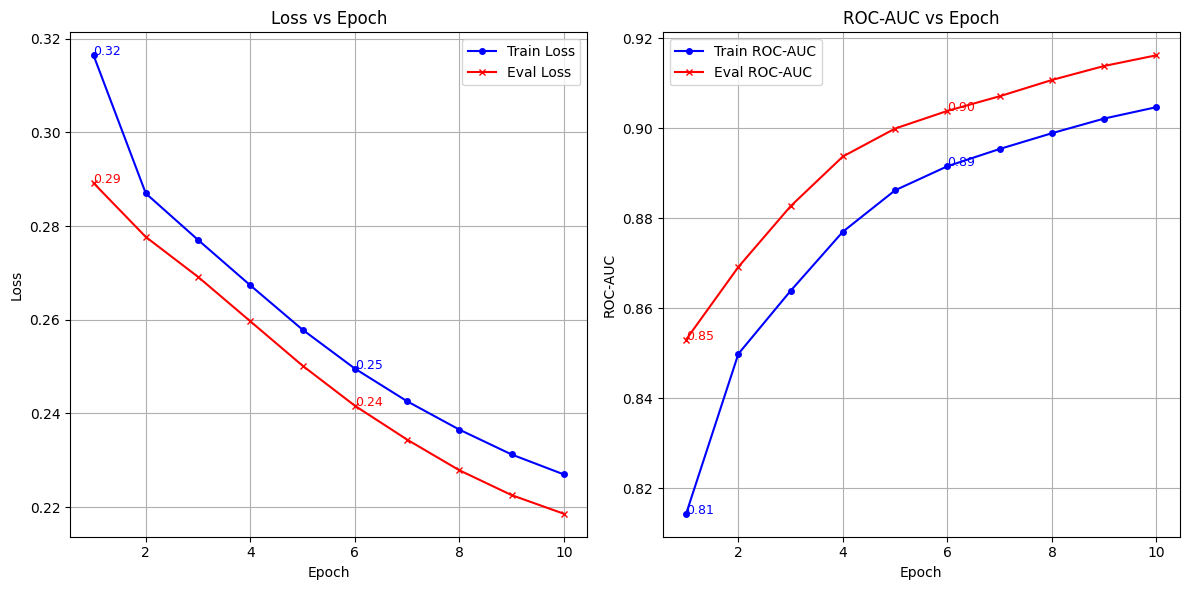

In [35]:
train(base_config, BaseModel, train_dataset, test_dataset)

  2%|▏         | 1/50 [00:12<10:07, 12.40s/it]

Epoch 1/50: Train Loss=0.3168, Train ROC-AUC=0.8140, Eval Loss=0.2896, Eval ROC-AUC=0.8529


  4%|▍         | 2/50 [00:24<09:52, 12.33s/it]

Epoch 2/50: Train Loss=0.2875, Train ROC-AUC=0.8494, Eval Loss=0.2783, Eval ROC-AUC=0.8683


  6%|▌         | 3/50 [00:37<09:42, 12.40s/it]

Epoch 3/50: Train Loss=0.2779, Train ROC-AUC=0.8630, Eval Loss=0.2701, Eval ROC-AUC=0.8811


  8%|▊         | 4/50 [00:49<09:27, 12.33s/it]

Epoch 4/50: Train Loss=0.2687, Train ROC-AUC=0.8756, Eval Loss=0.2612, Eval ROC-AUC=0.8920


 10%|█         | 5/50 [01:01<09:13, 12.29s/it]

Epoch 5/50: Train Loss=0.2598, Train ROC-AUC=0.8850, Eval Loss=0.2525, Eval ROC-AUC=0.8985


 12%|█▏        | 6/50 [01:13<09:00, 12.29s/it]

Epoch 6/50: Train Loss=0.2516, Train ROC-AUC=0.8907, Eval Loss=0.2441, Eval ROC-AUC=0.9026


 14%|█▍        | 7/50 [01:26<08:47, 12.26s/it]

Epoch 7/50: Train Loss=0.2444, Train ROC-AUC=0.8948, Eval Loss=0.2369, Eval ROC-AUC=0.9059


 16%|█▌        | 8/50 [01:38<08:35, 12.26s/it]

Epoch 8/50: Train Loss=0.2381, Train ROC-AUC=0.8984, Eval Loss=0.2306, Eval ROC-AUC=0.9093


 18%|█▊        | 9/50 [01:50<08:21, 12.23s/it]

Epoch 9/50: Train Loss=0.2327, Train ROC-AUC=0.9016, Eval Loss=0.2250, Eval ROC-AUC=0.9125


 20%|██        | 10/50 [02:02<08:09, 12.24s/it]

Epoch 10/50: Train Loss=0.2281, Train ROC-AUC=0.9044, Eval Loss=0.2206, Eval ROC-AUC=0.9151


 22%|██▏       | 11/50 [02:15<07:58, 12.26s/it]

Epoch 11/50: Train Loss=0.2246, Train ROC-AUC=0.9065, Eval Loss=0.2174, Eval ROC-AUC=0.9168


 24%|██▍       | 12/50 [02:27<07:44, 12.22s/it]

Epoch 12/50: Train Loss=0.2221, Train ROC-AUC=0.9080, Eval Loss=0.2152, Eval ROC-AUC=0.9179


 26%|██▌       | 13/50 [02:39<07:32, 12.24s/it]

Epoch 13/50: Train Loss=0.2204, Train ROC-AUC=0.9090, Eval Loss=0.2138, Eval ROC-AUC=0.9185


 28%|██▊       | 14/50 [02:51<07:20, 12.22s/it]

Epoch 14/50: Train Loss=0.2191, Train ROC-AUC=0.9097, Eval Loss=0.2129, Eval ROC-AUC=0.9188


 30%|███       | 15/50 [03:03<07:07, 12.22s/it]

Epoch 15/50: Train Loss=0.2181, Train ROC-AUC=0.9103, Eval Loss=0.2121, Eval ROC-AUC=0.9192


 32%|███▏      | 16/50 [03:16<06:56, 12.25s/it]

Epoch 16/50: Train Loss=0.2173, Train ROC-AUC=0.9107, Eval Loss=0.2119, Eval ROC-AUC=0.9194


 34%|███▍      | 17/50 [03:28<06:44, 12.25s/it]

Epoch 17/50: Train Loss=0.2167, Train ROC-AUC=0.9110, Eval Loss=0.2112, Eval ROC-AUC=0.9196


 36%|███▌      | 18/50 [03:41<06:37, 12.43s/it]

Epoch 18/50: Train Loss=0.2162, Train ROC-AUC=0.9114, Eval Loss=0.2106, Eval ROC-AUC=0.9198


 38%|███▊      | 19/50 [03:53<06:22, 12.33s/it]

Epoch 19/50: Train Loss=0.2157, Train ROC-AUC=0.9116, Eval Loss=0.2100, Eval ROC-AUC=0.9201


 40%|████      | 20/50 [04:05<06:08, 12.30s/it]

Epoch 20/50: Train Loss=0.2152, Train ROC-AUC=0.9119, Eval Loss=0.2099, Eval ROC-AUC=0.9201


 42%|████▏     | 21/50 [04:17<05:56, 12.30s/it]

Epoch 21/50: Train Loss=0.2146, Train ROC-AUC=0.9123, Eval Loss=0.2097, Eval ROC-AUC=0.9203


 44%|████▍     | 22/50 [04:30<05:43, 12.25s/it]

Epoch 22/50: Train Loss=0.2141, Train ROC-AUC=0.9126, Eval Loss=0.2093, Eval ROC-AUC=0.9208


 46%|████▌     | 23/50 [04:41<05:26, 12.08s/it]

Epoch 23/50: Train Loss=0.2135, Train ROC-AUC=0.9129, Eval Loss=0.2086, Eval ROC-AUC=0.9212


 48%|████▊     | 24/50 [04:53<05:10, 11.96s/it]

Epoch 24/50: Train Loss=0.2129, Train ROC-AUC=0.9132, Eval Loss=0.2075, Eval ROC-AUC=0.9215


 50%|█████     | 25/50 [05:05<05:01, 12.06s/it]

Epoch 25/50: Train Loss=0.2123, Train ROC-AUC=0.9136, Eval Loss=0.2078, Eval ROC-AUC=0.9216


 52%|█████▏    | 26/50 [05:18<04:51, 12.15s/it]

Epoch 26/50: Train Loss=0.2118, Train ROC-AUC=0.9138, Eval Loss=0.2075, Eval ROC-AUC=0.9218


 54%|█████▍    | 27/50 [05:30<04:40, 12.22s/it]

Epoch 27/50: Train Loss=0.2113, Train ROC-AUC=0.9141, Eval Loss=0.2071, Eval ROC-AUC=0.9220


 56%|█████▌    | 28/50 [05:42<04:30, 12.28s/it]

Epoch 28/50: Train Loss=0.2109, Train ROC-AUC=0.9143, Eval Loss=0.2067, Eval ROC-AUC=0.9223


 58%|█████▊    | 29/50 [05:55<04:19, 12.35s/it]

Epoch 29/50: Train Loss=0.2104, Train ROC-AUC=0.9146, Eval Loss=0.2064, Eval ROC-AUC=0.9225


 60%|██████    | 30/50 [06:07<04:06, 12.30s/it]

Epoch 30/50: Train Loss=0.2099, Train ROC-AUC=0.9149, Eval Loss=0.2059, Eval ROC-AUC=0.9227


 62%|██████▏   | 31/50 [06:19<03:53, 12.30s/it]

Epoch 31/50: Train Loss=0.2095, Train ROC-AUC=0.9152, Eval Loss=0.2057, Eval ROC-AUC=0.9230


 64%|██████▍   | 32/50 [06:32<03:40, 12.27s/it]

Epoch 32/50: Train Loss=0.2090, Train ROC-AUC=0.9154, Eval Loss=0.2053, Eval ROC-AUC=0.9232


 66%|██████▌   | 33/50 [06:44<03:28, 12.26s/it]

Epoch 33/50: Train Loss=0.2086, Train ROC-AUC=0.9157, Eval Loss=0.2048, Eval ROC-AUC=0.9235


 68%|██████▊   | 34/50 [06:56<03:16, 12.26s/it]

Epoch 34/50: Train Loss=0.2082, Train ROC-AUC=0.9159, Eval Loss=0.2044, Eval ROC-AUC=0.9238


 70%|███████   | 35/50 [07:08<03:03, 12.24s/it]

Epoch 35/50: Train Loss=0.2077, Train ROC-AUC=0.9162, Eval Loss=0.2039, Eval ROC-AUC=0.9240


 72%|███████▏  | 36/50 [07:21<02:51, 12.25s/it]

Epoch 36/50: Train Loss=0.2073, Train ROC-AUC=0.9165, Eval Loss=0.2039, Eval ROC-AUC=0.9243


 74%|███████▍  | 37/50 [07:33<02:38, 12.22s/it]

Epoch 37/50: Train Loss=0.2069, Train ROC-AUC=0.9167, Eval Loss=0.2029, Eval ROC-AUC=0.9246


 76%|███████▌  | 38/50 [07:45<02:26, 12.23s/it]

Epoch 38/50: Train Loss=0.2064, Train ROC-AUC=0.9170, Eval Loss=0.2025, Eval ROC-AUC=0.9249


 78%|███████▊  | 39/50 [07:57<02:14, 12.25s/it]

Epoch 39/50: Train Loss=0.2060, Train ROC-AUC=0.9172, Eval Loss=0.2020, Eval ROC-AUC=0.9251


 80%|████████  | 40/50 [08:09<02:02, 12.22s/it]

Epoch 40/50: Train Loss=0.2056, Train ROC-AUC=0.9175, Eval Loss=0.2020, Eval ROC-AUC=0.9253


 82%|████████▏ | 41/50 [08:22<01:49, 12.22s/it]

Epoch 41/50: Train Loss=0.2053, Train ROC-AUC=0.9177, Eval Loss=0.2015, Eval ROC-AUC=0.9255


 84%|████████▍ | 42/50 [08:34<01:37, 12.23s/it]

Epoch 42/50: Train Loss=0.2049, Train ROC-AUC=0.9179, Eval Loss=0.2010, Eval ROC-AUC=0.9258


 86%|████████▌ | 43/50 [08:46<01:25, 12.25s/it]

Epoch 43/50: Train Loss=0.2045, Train ROC-AUC=0.9181, Eval Loss=0.2008, Eval ROC-AUC=0.9259


 88%|████████▊ | 44/50 [08:58<01:13, 12.27s/it]

Epoch 44/50: Train Loss=0.2041, Train ROC-AUC=0.9184, Eval Loss=0.2003, Eval ROC-AUC=0.9261


 90%|█████████ | 45/50 [09:11<01:01, 12.22s/it]

Epoch 45/50: Train Loss=0.2038, Train ROC-AUC=0.9186, Eval Loss=0.1997, Eval ROC-AUC=0.9263


 92%|█████████▏| 46/50 [09:23<00:48, 12.16s/it]

Epoch 46/50: Train Loss=0.2034, Train ROC-AUC=0.9188, Eval Loss=0.1994, Eval ROC-AUC=0.9265


 94%|█████████▍| 47/50 [09:35<00:36, 12.25s/it]

Epoch 47/50: Train Loss=0.2030, Train ROC-AUC=0.9191, Eval Loss=0.1989, Eval ROC-AUC=0.9268


 96%|█████████▌| 48/50 [09:48<00:24, 12.50s/it]

Epoch 48/50: Train Loss=0.2025, Train ROC-AUC=0.9194, Eval Loss=0.1980, Eval ROC-AUC=0.9273


 98%|█████████▊| 49/50 [10:01<00:12, 12.49s/it]

Epoch 49/50: Train Loss=0.2020, Train ROC-AUC=0.9198, Eval Loss=0.1976, Eval ROC-AUC=0.9276


100%|██████████| 50/50 [10:13<00:00, 12.27s/it]

Epoch 50/50: Train Loss=0.2016, Train ROC-AUC=0.9200, Eval Loss=0.1974, Eval ROC-AUC=0.9277


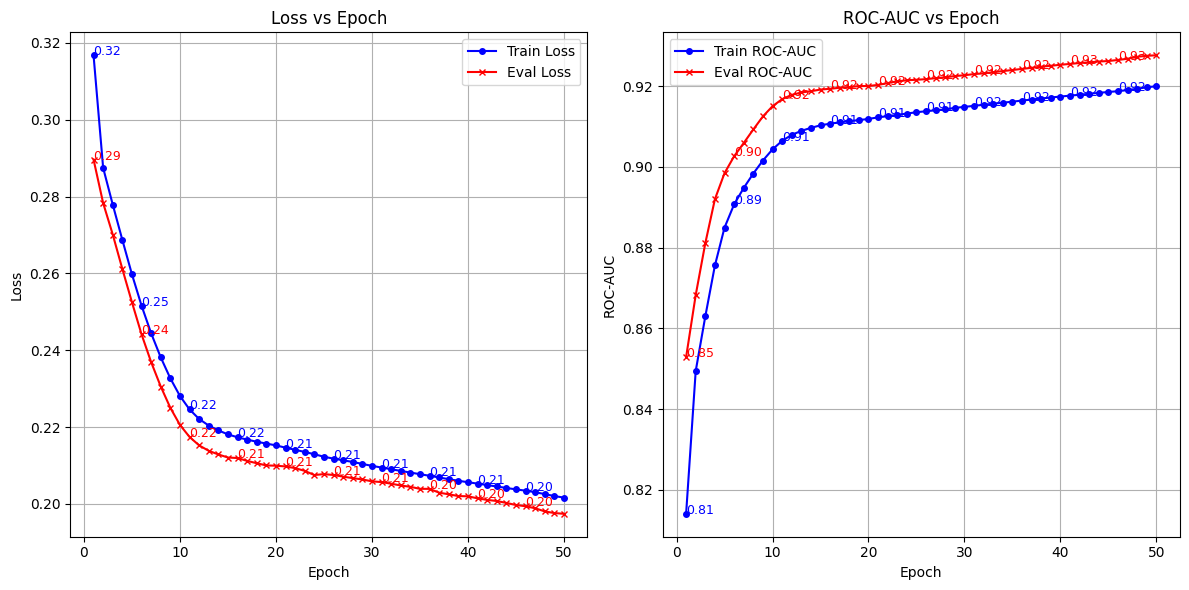

In [29]:
base_config.num_epochs = 50
train(base_config, BaseModel, train_dataset, test_dataset)

# Эксперимент 2. Модель побольше

In [42]:
medium_config = Config(experiment_name='MediumModel',
                     batch_size=32, 
                     hidden_size=128, 
                     lr=0.01, 
                     num_epochs=10, 
                     seed=42)

In [43]:
class MediumBlock(nn.Module):
    def __init__(self, hidden_size: int):
        super().__init__()
        self.linear_1 = nn.Linear(hidden_size, hidden_size * 4)
        self.act = nn.LeakyReLU()
        self.linear_2 = nn.Linear(hidden_size * 4, hidden_size)

    def forward(self, x: Tensor) -> Tensor:
        x = self.linear_1(x)
        x = self.act(x)
        x = self.linear_2(x)
        return x 


class MediumModel(nn.Module):
    def __init__(
            self,
           config: Config,
    ):
        super().__init__()

        self.emb_home = nn.Embedding(4, config.hidden_size)
        self.emb_intent = nn.Embedding(6, config.hidden_size)
        self.emb_grade = nn.Embedding(7, config.hidden_size)
        self.emb_default = nn.Embedding(2, config.hidden_size)

        self.numeric_proj = nn.Linear(7, config.hidden_size)
        self.blocks = nn.Sequential(
            *[MediumBlock(config.hidden_size) for _ in range(3)]
        )

        self.output = nn.Linear(config.hidden_size, 1)

    def forward(
            self,
            cat_features: dict[str, Tensor],
            numeric_features: dict[str, Tensor]
    ) -> Tensor:
        x_home = self.emb_home(cat_features['home'])
        x_intent = self.emb_intent(cat_features['intent'])
        x_grade = self.emb_grade(cat_features['grade'])
        x_default = self.emb_default(cat_features['cpdof'])

        numeric_stack = torch.stack([
            numeric_features['age'],
            numeric_features['income'],
            numeric_features['emp'],
            numeric_features['amnt'],
            numeric_features['rate'],
            numeric_features['p_income'],
            numeric_features['cred_hist']
        ], dim=-1)

        x_numeric = self.numeric_proj(numeric_stack)
        x = x_home + x_intent + x_grade + x_default + x_numeric
        x = self.blocks(x)

        return self.output(x).squeeze(-1)

 10%|█         | 1/10 [00:13<01:58, 13.18s/it]

Epoch 1/10: Train Loss=0.3365, Train ROC-AUC=0.7872, Eval Loss=0.2922, Eval ROC-AUC=0.8480


 20%|██        | 2/10 [00:26<01:45, 13.19s/it]

Epoch 2/10: Train Loss=0.2873, Train ROC-AUC=0.8447, Eval Loss=0.2779, Eval ROC-AUC=0.8781


 30%|███       | 3/10 [00:39<01:32, 13.20s/it]

Epoch 3/10: Train Loss=0.2721, Train ROC-AUC=0.8662, Eval Loss=0.2633, Eval ROC-AUC=0.8940


 40%|████      | 4/10 [00:52<01:19, 13.25s/it]

Epoch 4/10: Train Loss=0.2592, Train ROC-AUC=0.8802, Eval Loss=0.2494, Eval ROC-AUC=0.9015


 50%|█████     | 5/10 [01:06<01:06, 13.24s/it]

Epoch 5/10: Train Loss=0.2488, Train ROC-AUC=0.8893, Eval Loss=0.2392, Eval ROC-AUC=0.9078


 60%|██████    | 6/10 [01:19<00:53, 13.25s/it]

Epoch 6/10: Train Loss=0.2402, Train ROC-AUC=0.8958, Eval Loss=0.2302, Eval ROC-AUC=0.9129


 70%|███████   | 7/10 [01:32<00:39, 13.23s/it]

Epoch 7/10: Train Loss=0.2330, Train ROC-AUC=0.9008, Eval Loss=0.2233, Eval ROC-AUC=0.9165


 80%|████████  | 8/10 [01:45<00:26, 13.26s/it]

Epoch 8/10: Train Loss=0.2273, Train ROC-AUC=0.9043, Eval Loss=0.2185, Eval ROC-AUC=0.9191


 90%|█████████ | 9/10 [01:59<00:13, 13.22s/it]

Epoch 9/10: Train Loss=0.2228, Train ROC-AUC=0.9069, Eval Loss=0.2159, Eval ROC-AUC=0.9205


100%|██████████| 10/10 [02:12<00:00, 13.24s/it]

Epoch 10/10: Train Loss=0.2193, Train ROC-AUC=0.9089, Eval Loss=0.2122, Eval ROC-AUC=0.9214


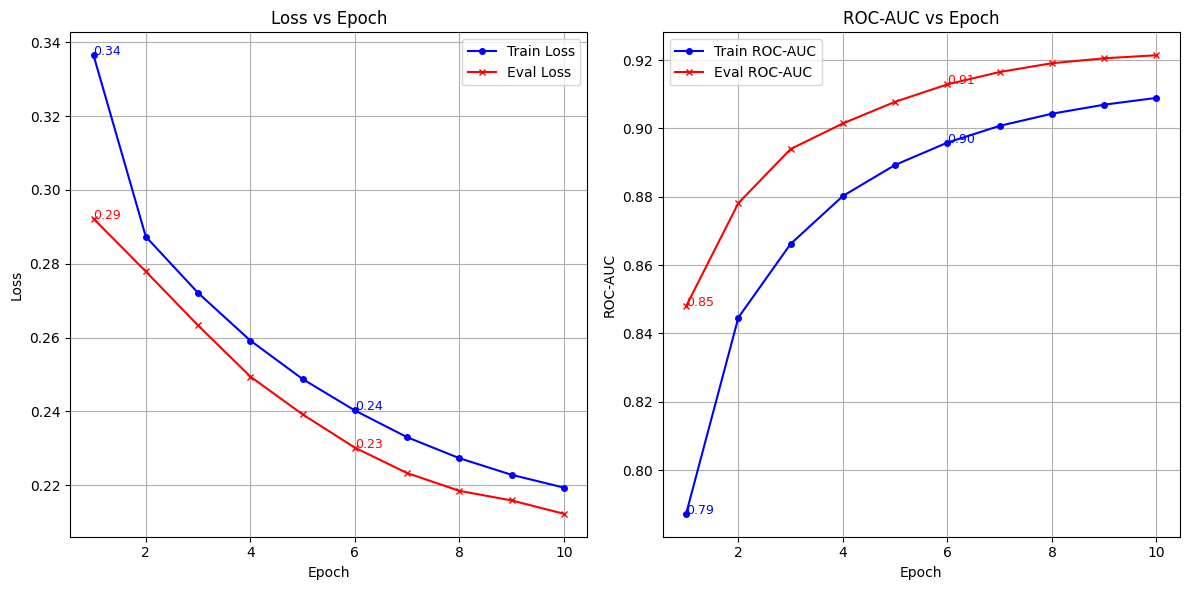

In [44]:
train(medium_config, MediumModel, train_dataset, test_dataset)

# Эксперимент 3. Skip Connections, Batch Norms

In [61]:
class SkipConnectionsBlock(nn.Module):
    def __init__(self, hidden_size: int):
        super().__init__()
        self.bn = nn.BatchNorm1d(hidden_size)
        self.linear_1 = nn.Linear(hidden_size, hidden_size * 4)
        self.act = nn.LeakyReLU()
        self.linear_2 = nn.Linear(hidden_size * 4, hidden_size)

    def forward(self, x: Tensor) -> Tensor:
        residual = x
        x = self.bn(x)
        x = self.linear_1(x)
        x = self.act(x)
        x = self.linear_2(x)
        return x + residual


class SkipConnectionsModel(nn.Module):
    def __init__(
            self,
           config: Config,
    ):
        super().__init__()

        self.emb_home = nn.Embedding(4, config.hidden_size)
        self.emb_intent = nn.Embedding(6, config.hidden_size)
        self.emb_grade = nn.Embedding(7, config.hidden_size)
        self.emb_default = nn.Embedding(2, config.hidden_size)

        self.numeric_proj = nn.Linear(7, config.hidden_size)
        self.blocks = nn.Sequential(
            *[SkipConnectionsBlock(config.hidden_size) for _ in range(3)]
        )

        self.output = nn.Linear(config.hidden_size, 1)

    def forward(
            self,
            cat_features: dict[str, Tensor],
            numeric_features: dict[str, Tensor]
    ) -> Tensor:
        x_home = self.emb_home(cat_features['home'])
        x_intent = self.emb_intent(cat_features['intent'])
        x_grade = self.emb_grade(cat_features['grade'])
        x_default = self.emb_default(cat_features['cpdof'])

        numeric_stack = torch.stack([
            numeric_features['age'],
            numeric_features['income'],
            numeric_features['emp'],
            numeric_features['amnt'],
            numeric_features['rate'],
            numeric_features['p_income'],
            numeric_features['cred_hist']
        ], dim=-1)

        x_numeric = self.numeric_proj(numeric_stack)
        x = x_home + x_intent + x_grade + x_default + x_numeric
        x = self.blocks(x)

        return self.output(x).squeeze(-1)

cuda


 10%|█         | 1/10 [00:14<02:11, 14.60s/it]

Epoch 1/10: Train Loss=0.2932, Train ROC-AUC=0.8384, Eval Loss=0.2747, Eval ROC-AUC=0.8806


 20%|██        | 2/10 [00:29<01:57, 14.68s/it]

Epoch 2/10: Train Loss=0.2695, Train ROC-AUC=0.8717, Eval Loss=0.2617, Eval ROC-AUC=0.8950


 30%|███       | 3/10 [00:43<01:42, 14.61s/it]

Epoch 3/10: Train Loss=0.2564, Train ROC-AUC=0.8843, Eval Loss=0.2521, Eval ROC-AUC=0.8995


 40%|████      | 4/10 [00:58<01:27, 14.63s/it]

Epoch 4/10: Train Loss=0.2461, Train ROC-AUC=0.8922, Eval Loss=0.2461, Eval ROC-AUC=0.9033


 50%|█████     | 5/10 [01:12<01:12, 14.57s/it]

Epoch 5/10: Train Loss=0.2376, Train ROC-AUC=0.8982, Eval Loss=0.2433, Eval ROC-AUC=0.9062


 60%|██████    | 6/10 [01:27<00:57, 14.40s/it]

Epoch 6/10: Train Loss=0.2317, Train ROC-AUC=0.9024, Eval Loss=0.2421, Eval ROC-AUC=0.9078


 70%|███████   | 7/10 [01:40<00:42, 14.20s/it]

Epoch 7/10: Train Loss=0.2277, Train ROC-AUC=0.9053, Eval Loss=0.2404, Eval ROC-AUC=0.9091


 80%|████████  | 8/10 [01:55<00:28, 14.36s/it]

Epoch 8/10: Train Loss=0.2247, Train ROC-AUC=0.9075, Eval Loss=0.2390, Eval ROC-AUC=0.9099


 90%|█████████ | 9/10 [02:10<00:14, 14.46s/it]

Epoch 9/10: Train Loss=0.2221, Train ROC-AUC=0.9093, Eval Loss=0.2367, Eval ROC-AUC=0.9109


100%|██████████| 10/10 [02:24<00:00, 14.48s/it]

Epoch 10/10: Train Loss=0.2199, Train ROC-AUC=0.9108, Eval Loss=0.2346, Eval ROC-AUC=0.9119


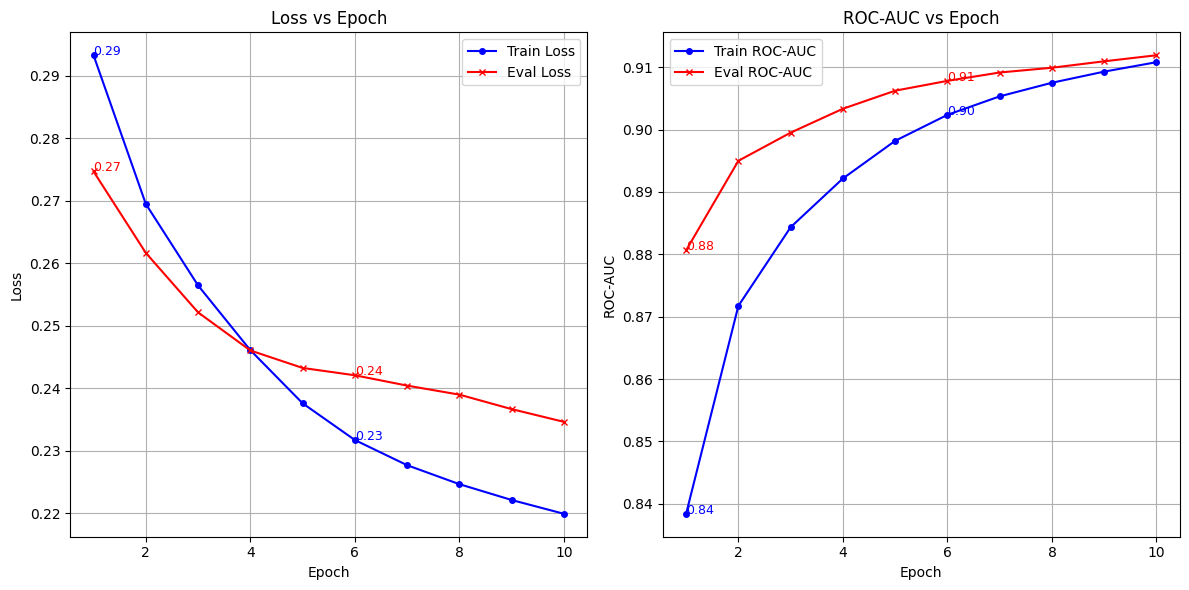

In [62]:
train(medium_config, SkipConnectionsModel, train_dataset, test_dataset)

# Эксперимент 4. Dropout

In [72]:
class DropoutBlock(nn.Module):
    def __init__(self, hidden_size: int, dropout_p: float):
        super().__init__()
        self.bn = nn.BatchNorm1d(hidden_size)
        self.linear_1 = nn.Linear(hidden_size, hidden_size * 4)
        self.act = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout_p)  
        self.linear_2 = nn.Linear(hidden_size * 4, hidden_size)

    def forward(self, x: Tensor) -> Tensor:
        residual = x
        x = self.bn(x)
        x = self.linear_1(x)
        x = self.act(x)
        x = self.dropout(x)  
        x = self.linear_2(x)
        return x + residual


class DropoutModel(nn.Module):
    def __init__(
            self,
            config: Config,
    ):
        super().__init__()

        self.emb_home = nn.Embedding(4, config.hidden_size)
        self.emb_intent = nn.Embedding(6, config.hidden_size)
        self.emb_grade = nn.Embedding(7, config.hidden_size)
        self.emb_default = nn.Embedding(2, config.hidden_size)

        self.numeric_proj = nn.Linear(7, config.hidden_size)
        self.blocks = nn.Sequential(
            *[DropoutBlock(config.hidden_size, config.drop_p) for _ in range(3)]
        )

        self.output = nn.Linear(config.hidden_size, 1)

        self.emb_dropout = nn.Dropout(config.drop_p)

    def forward(
            self,
            cat_features: dict[str, Tensor],
            numeric_features: dict[str, Tensor]
    ) -> Tensor:
        x_home = self.emb_dropout(self.emb_home(cat_features['home']))
        x_intent = self.emb_dropout(self.emb_intent(cat_features['intent']))
        x_grade = self.emb_dropout(self.emb_grade(cat_features['grade']))
        x_default = self.emb_dropout(self.emb_default(cat_features['cpdof']))

        numeric_stack = torch.stack([
            numeric_features['age'],
            numeric_features['income'],
            numeric_features['emp'],
            numeric_features['amnt'],
            numeric_features['rate'],
            numeric_features['p_income'],
            numeric_features['cred_hist']
        ], dim=-1)

        x_numeric = self.numeric_proj(numeric_stack)
        x = x_home + x_intent + x_grade + x_default + x_numeric
        x = self.blocks(x)

        return self.output(x).squeeze(-1)

Training with config: Config(experiment_name='DropoutModel', seed=42, batch_size=32, hidden_size=128, lr=0.01, num_epochs=10, weight_decay=0, drop_p=0.01)
cuda


 10%|█         | 1/10 [00:15<02:17, 15.24s/it]

Epoch 1/10: Train Loss=0.2955, Train ROC-AUC=0.8350, Eval Loss=0.2764, Eval ROC-AUC=0.8774


 20%|██        | 2/10 [00:30<02:01, 15.13s/it]

Epoch 2/10: Train Loss=0.2751, Train ROC-AUC=0.8636, Eval Loss=0.2659, Eval ROC-AUC=0.8941


 30%|███       | 3/10 [00:45<01:46, 15.15s/it]

Epoch 3/10: Train Loss=0.2666, Train ROC-AUC=0.8736, Eval Loss=0.2594, Eval ROC-AUC=0.8977


 40%|████      | 4/10 [01:00<01:30, 15.11s/it]

Epoch 4/10: Train Loss=0.2597, Train ROC-AUC=0.8805, Eval Loss=0.2543, Eval ROC-AUC=0.9009


 50%|█████     | 5/10 [01:15<01:15, 15.13s/it]

Epoch 5/10: Train Loss=0.2558, Train ROC-AUC=0.8834, Eval Loss=0.2448, Eval ROC-AUC=0.9073


 60%|██████    | 6/10 [01:30<01:00, 15.09s/it]

Epoch 6/10: Train Loss=0.2507, Train ROC-AUC=0.8887, Eval Loss=0.2455, Eval ROC-AUC=0.9097


 70%|███████   | 7/10 [01:45<00:45, 15.10s/it]

Epoch 7/10: Train Loss=0.2470, Train ROC-AUC=0.8906, Eval Loss=0.2383, Eval ROC-AUC=0.9111


 80%|████████  | 8/10 [02:00<00:30, 15.12s/it]

Epoch 8/10: Train Loss=0.2449, Train ROC-AUC=0.8929, Eval Loss=0.2396, Eval ROC-AUC=0.9134


 90%|█████████ | 9/10 [02:16<00:15, 15.13s/it]

Epoch 9/10: Train Loss=0.2413, Train ROC-AUC=0.8958, Eval Loss=0.2335, Eval ROC-AUC=0.9147


100%|██████████| 10/10 [02:31<00:00, 15.13s/it]

Epoch 10/10: Train Loss=0.2393, Train ROC-AUC=0.8972, Eval Loss=0.2352, Eval ROC-AUC=0.9137


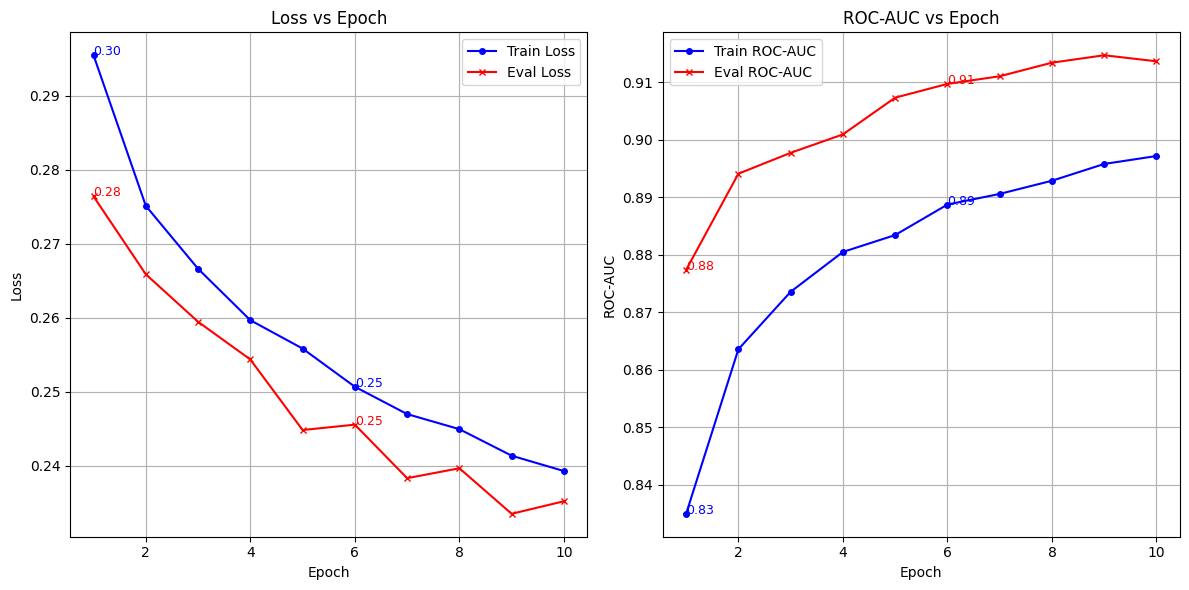

Training with config: Config(experiment_name='DropoutModel', seed=42, batch_size=32, hidden_size=128, lr=0.01, num_epochs=10, weight_decay=0, drop_p=0.1)
cuda


 10%|█         | 1/10 [00:15<02:18, 15.42s/it]

Epoch 1/10: Train Loss=0.3069, Train ROC-AUC=0.8204, Eval Loss=0.2847, Eval ROC-AUC=0.8598


 20%|██        | 2/10 [00:30<02:02, 15.29s/it]

Epoch 2/10: Train Loss=0.2936, Train ROC-AUC=0.8379, Eval Loss=0.2787, Eval ROC-AUC=0.8778


 30%|███       | 3/10 [00:45<01:44, 14.92s/it]

Epoch 3/10: Train Loss=0.2896, Train ROC-AUC=0.8429, Eval Loss=0.2768, Eval ROC-AUC=0.8825


 40%|████      | 4/10 [00:59<01:28, 14.72s/it]

Epoch 4/10: Train Loss=0.2864, Train ROC-AUC=0.8466, Eval Loss=0.2751, Eval ROC-AUC=0.8872


 50%|█████     | 5/10 [01:14<01:14, 14.88s/it]

Epoch 5/10: Train Loss=0.2859, Train ROC-AUC=0.8472, Eval Loss=0.2727, Eval ROC-AUC=0.8855


 60%|██████    | 6/10 [01:29<00:59, 14.98s/it]

Epoch 6/10: Train Loss=0.2828, Train ROC-AUC=0.8514, Eval Loss=0.2726, Eval ROC-AUC=0.8892


 70%|███████   | 7/10 [01:45<00:45, 15.24s/it]

Epoch 7/10: Train Loss=0.2821, Train ROC-AUC=0.8523, Eval Loss=0.2690, Eval ROC-AUC=0.8927


 80%|████████  | 8/10 [02:00<00:30, 15.23s/it]

Epoch 8/10: Train Loss=0.2804, Train ROC-AUC=0.8553, Eval Loss=0.2668, Eval ROC-AUC=0.8925


 90%|█████████ | 9/10 [02:15<00:15, 15.16s/it]

Epoch 9/10: Train Loss=0.2787, Train ROC-AUC=0.8573, Eval Loss=0.2675, Eval ROC-AUC=0.8935


100%|██████████| 10/10 [02:31<00:00, 15.11s/it]

Epoch 10/10: Train Loss=0.2770, Train ROC-AUC=0.8588, Eval Loss=0.2673, Eval ROC-AUC=0.8967


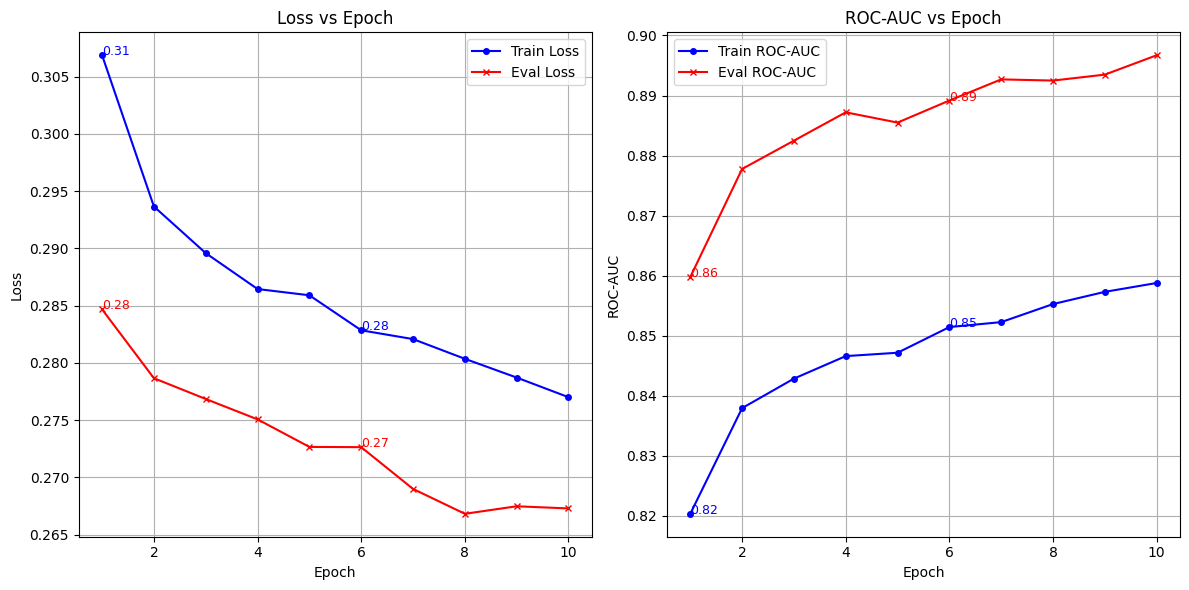

Training with config: Config(experiment_name='DropoutModel', seed=42, batch_size=32, hidden_size=128, lr=0.01, num_epochs=10, weight_decay=0, drop_p=0.2)
cuda


 10%|█         | 1/10 [00:15<02:16, 15.19s/it]

Epoch 1/10: Train Loss=0.3151, Train ROC-AUC=0.8104, Eval Loss=0.2914, Eval ROC-AUC=0.8476


 20%|██        | 2/10 [00:30<02:02, 15.26s/it]

Epoch 2/10: Train Loss=0.3052, Train ROC-AUC=0.8224, Eval Loss=0.2858, Eval ROC-AUC=0.8592


 30%|███       | 3/10 [00:45<01:46, 15.19s/it]

Epoch 3/10: Train Loss=0.3012, Train ROC-AUC=0.8272, Eval Loss=0.2849, Eval ROC-AUC=0.8625


 40%|████      | 4/10 [01:00<01:31, 15.26s/it]

Epoch 4/10: Train Loss=0.2987, Train ROC-AUC=0.8291, Eval Loss=0.2799, Eval ROC-AUC=0.8712


 50%|█████     | 5/10 [01:15<01:15, 15.16s/it]

Epoch 5/10: Train Loss=0.2968, Train ROC-AUC=0.8327, Eval Loss=0.2811, Eval ROC-AUC=0.8715


 60%|██████    | 6/10 [01:31<01:00, 15.21s/it]

Epoch 6/10: Train Loss=0.2935, Train ROC-AUC=0.8369, Eval Loss=0.2800, Eval ROC-AUC=0.8735


 70%|███████   | 7/10 [01:46<00:45, 15.15s/it]

Epoch 7/10: Train Loss=0.2937, Train ROC-AUC=0.8353, Eval Loss=0.2777, Eval ROC-AUC=0.8757


 80%|████████  | 8/10 [02:01<00:30, 15.24s/it]

Epoch 8/10: Train Loss=0.2924, Train ROC-AUC=0.8370, Eval Loss=0.2767, Eval ROC-AUC=0.8767


 90%|█████████ | 9/10 [02:16<00:15, 15.14s/it]

Epoch 9/10: Train Loss=0.2917, Train ROC-AUC=0.8392, Eval Loss=0.2781, Eval ROC-AUC=0.8780


100%|██████████| 10/10 [02:32<00:00, 15.23s/it]

Epoch 10/10: Train Loss=0.2903, Train ROC-AUC=0.8388, Eval Loss=0.2760, Eval ROC-AUC=0.8804


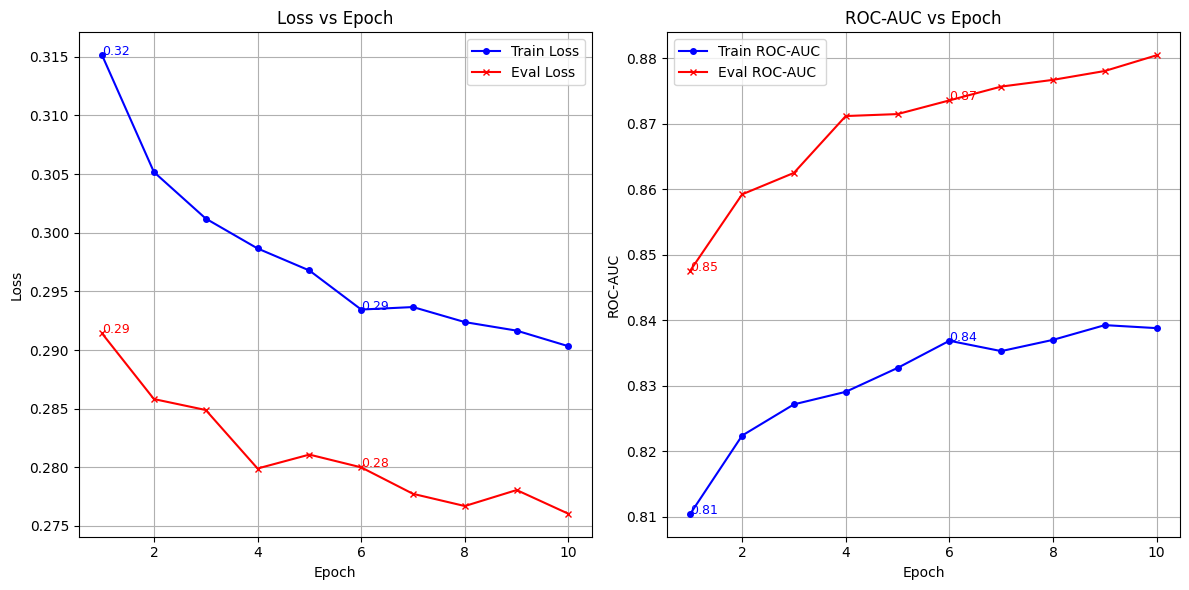

Training with config: Config(experiment_name='DropoutModel', seed=42, batch_size=32, hidden_size=128, lr=0.01, num_epochs=10, weight_decay=0, drop_p=0.5)
cuda


 10%|█         | 1/10 [00:14<02:10, 14.47s/it]

Epoch 1/10: Train Loss=0.3358, Train ROC-AUC=0.7832, Eval Loss=0.3002, Eval ROC-AUC=0.8372


 20%|██        | 2/10 [00:29<01:57, 14.65s/it]

Epoch 2/10: Train Loss=0.3287, Train ROC-AUC=0.7905, Eval Loss=0.2974, Eval ROC-AUC=0.8396


 30%|███       | 3/10 [00:44<01:44, 14.87s/it]

Epoch 3/10: Train Loss=0.3245, Train ROC-AUC=0.7970, Eval Loss=0.3023, Eval ROC-AUC=0.8362


 40%|████      | 4/10 [00:59<01:30, 15.11s/it]

Epoch 4/10: Train Loss=0.3260, Train ROC-AUC=0.7957, Eval Loss=0.2955, Eval ROC-AUC=0.8368


 50%|█████     | 5/10 [01:15<01:15, 15.14s/it]

Epoch 5/10: Train Loss=0.3243, Train ROC-AUC=0.7986, Eval Loss=0.2948, Eval ROC-AUC=0.8420


 60%|██████    | 6/10 [01:30<01:00, 15.22s/it]

Epoch 6/10: Train Loss=0.3203, Train ROC-AUC=0.8042, Eval Loss=0.2913, Eval ROC-AUC=0.8441


 70%|███████   | 7/10 [01:45<00:45, 15.27s/it]

Epoch 7/10: Train Loss=0.3213, Train ROC-AUC=0.8018, Eval Loss=0.2915, Eval ROC-AUC=0.8441


 80%|████████  | 8/10 [02:01<00:30, 15.34s/it]

Epoch 8/10: Train Loss=0.3213, Train ROC-AUC=0.8015, Eval Loss=0.2901, Eval ROC-AUC=0.8473


 90%|█████████ | 9/10 [02:16<00:15, 15.35s/it]

Epoch 9/10: Train Loss=0.3199, Train ROC-AUC=0.8043, Eval Loss=0.2892, Eval ROC-AUC=0.8473


100%|██████████| 10/10 [02:31<00:00, 15.17s/it]

Epoch 10/10: Train Loss=0.3182, Train ROC-AUC=0.8053, Eval Loss=0.2877, Eval ROC-AUC=0.8517


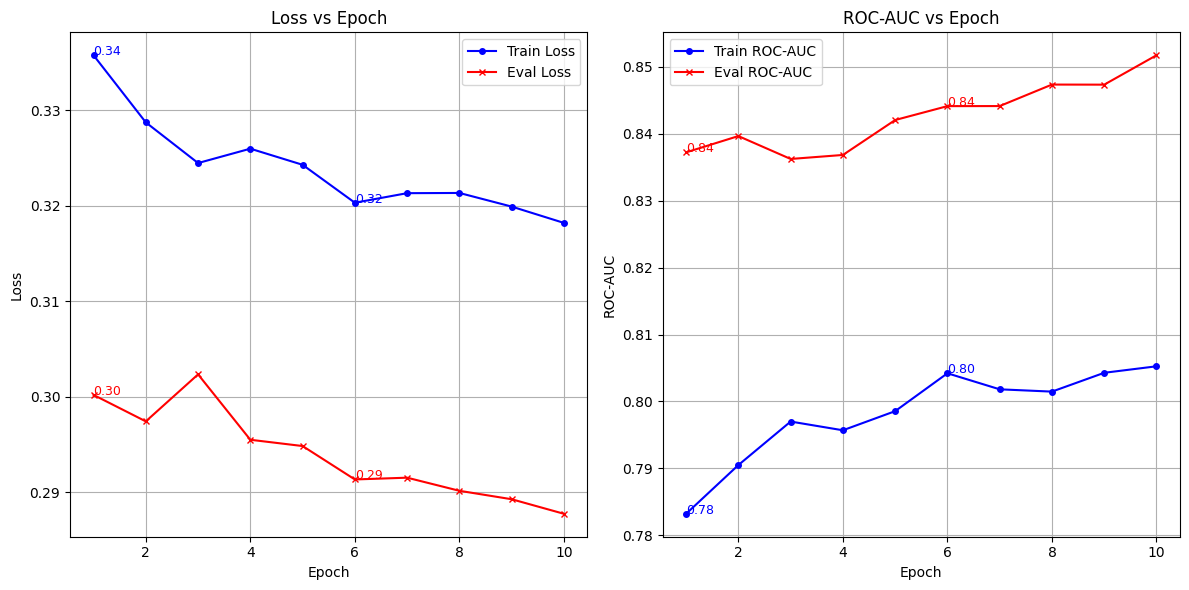

Training with config: Config(experiment_name='DropoutModel', seed=42, batch_size=32, hidden_size=128, lr=0.01, num_epochs=10, weight_decay=0, drop_p=0.9)
cuda


 10%|█         | 1/10 [00:16<02:25, 16.16s/it]

Epoch 1/10: Train Loss=0.4438, Train ROC-AUC=0.6520, Eval Loss=0.3315, Eval ROC-AUC=0.7972


 20%|██        | 2/10 [00:31<02:04, 15.53s/it]

Epoch 2/10: Train Loss=0.4265, Train ROC-AUC=0.6614, Eval Loss=0.3424, Eval ROC-AUC=0.7898


 30%|███       | 3/10 [00:46<01:47, 15.38s/it]

Epoch 3/10: Train Loss=0.4211, Train ROC-AUC=0.6675, Eval Loss=0.3314, Eval ROC-AUC=0.8059


 40%|████      | 4/10 [01:01<01:31, 15.32s/it]

Epoch 4/10: Train Loss=0.4213, Train ROC-AUC=0.6674, Eval Loss=0.3403, Eval ROC-AUC=0.8041


 50%|█████     | 5/10 [01:16<01:16, 15.29s/it]

Epoch 5/10: Train Loss=0.4181, Train ROC-AUC=0.6717, Eval Loss=0.3354, Eval ROC-AUC=0.8196


 60%|██████    | 6/10 [01:32<01:01, 15.26s/it]

Epoch 6/10: Train Loss=0.4143, Train ROC-AUC=0.6790, Eval Loss=0.3261, Eval ROC-AUC=0.8076


 70%|███████   | 7/10 [01:47<00:45, 15.24s/it]

Epoch 7/10: Train Loss=0.4174, Train ROC-AUC=0.6694, Eval Loss=0.3445, Eval ROC-AUC=0.7941


 80%|████████  | 8/10 [02:02<00:30, 15.21s/it]

Epoch 8/10: Train Loss=0.4149, Train ROC-AUC=0.6757, Eval Loss=0.3259, Eval ROC-AUC=0.8167


 90%|█████████ | 9/10 [02:16<00:14, 14.93s/it]

Epoch 9/10: Train Loss=0.4148, Train ROC-AUC=0.6746, Eval Loss=0.3286, Eval ROC-AUC=0.8131


100%|██████████| 10/10 [02:31<00:00, 15.15s/it]

Epoch 10/10: Train Loss=0.4126, Train ROC-AUC=0.6783, Eval Loss=0.3314, Eval ROC-AUC=0.8088


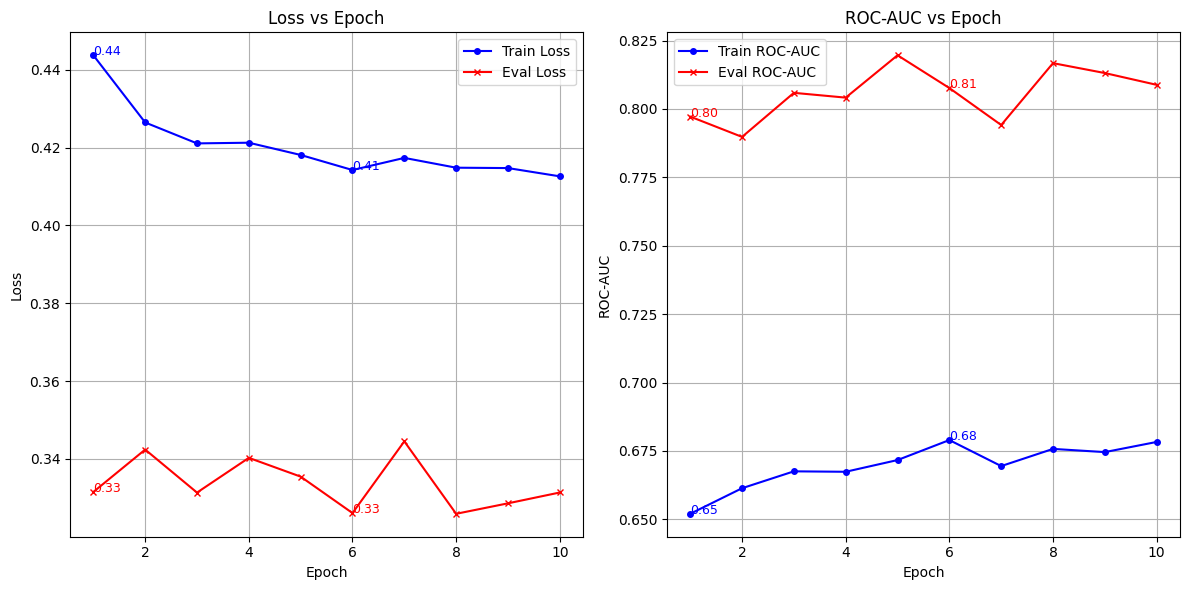

In [81]:
dropout_config = Config(experiment_name='DropoutModel',
                         batch_size=32, 
                         hidden_size=128, 
                         lr=0.01, 
                         num_epochs=10, 
                         seed=42)
dropout_values = [0.01, 0.1, 0.2, 0.5, 0.9]
for dropout_p in dropout_values:
    dropout_config.drop_p = dropout_p
    print(f'Training with config: {dropout_config}')
    train(dropout_config, DropoutModel, train_dataset, test_dataset)

# Эксперимент 5. Weight Decay, Learning Rate

Training with config: Config(experiment_name='BaseModel', seed=42, batch_size=32, hidden_size=128, lr=0.01, num_epochs=10, weight_decay=0.1, drop_p=0)
cuda


 10%|█         | 1/10 [00:14<02:12, 14.77s/it]

Epoch 1/10: Train Loss=0.3174, Train ROC-AUC=0.8162, Eval Loss=0.3327, Eval ROC-AUC=0.8274


 20%|██        | 2/10 [00:29<01:58, 14.79s/it]

Epoch 2/10: Train Loss=0.3536, Train ROC-AUC=0.8098, Eval Loss=0.3680, Eval ROC-AUC=0.8200


 30%|███       | 3/10 [00:44<01:43, 14.76s/it]

Epoch 3/10: Train Loss=0.3732, Train ROC-AUC=0.8066, Eval Loss=0.3763, Eval ROC-AUC=0.8173


 40%|████      | 4/10 [00:58<01:28, 14.71s/it]

Epoch 4/10: Train Loss=0.3772, Train ROC-AUC=0.8031, Eval Loss=0.3779, Eval ROC-AUC=0.8153


 50%|█████     | 5/10 [01:13<01:13, 14.67s/it]

Epoch 5/10: Train Loss=0.3781, Train ROC-AUC=0.8018, Eval Loss=0.3783, Eval ROC-AUC=0.8148


 60%|██████    | 6/10 [01:28<00:58, 14.71s/it]

Epoch 6/10: Train Loss=0.3783, Train ROC-AUC=0.8014, Eval Loss=0.3784, Eval ROC-AUC=0.8147


 70%|███████   | 7/10 [01:43<00:44, 14.73s/it]

Epoch 7/10: Train Loss=0.3783, Train ROC-AUC=0.8014, Eval Loss=0.3784, Eval ROC-AUC=0.8146


 80%|████████  | 8/10 [01:57<00:29, 14.76s/it]

Epoch 8/10: Train Loss=0.3783, Train ROC-AUC=0.8013, Eval Loss=0.3784, Eval ROC-AUC=0.8146


 90%|█████████ | 9/10 [02:12<00:14, 14.72s/it]

Epoch 9/10: Train Loss=0.3783, Train ROC-AUC=0.8013, Eval Loss=0.3784, Eval ROC-AUC=0.8146


100%|██████████| 10/10 [02:27<00:00, 14.73s/it]

Epoch 10/10: Train Loss=0.3783, Train ROC-AUC=0.8013, Eval Loss=0.3784, Eval ROC-AUC=0.8146


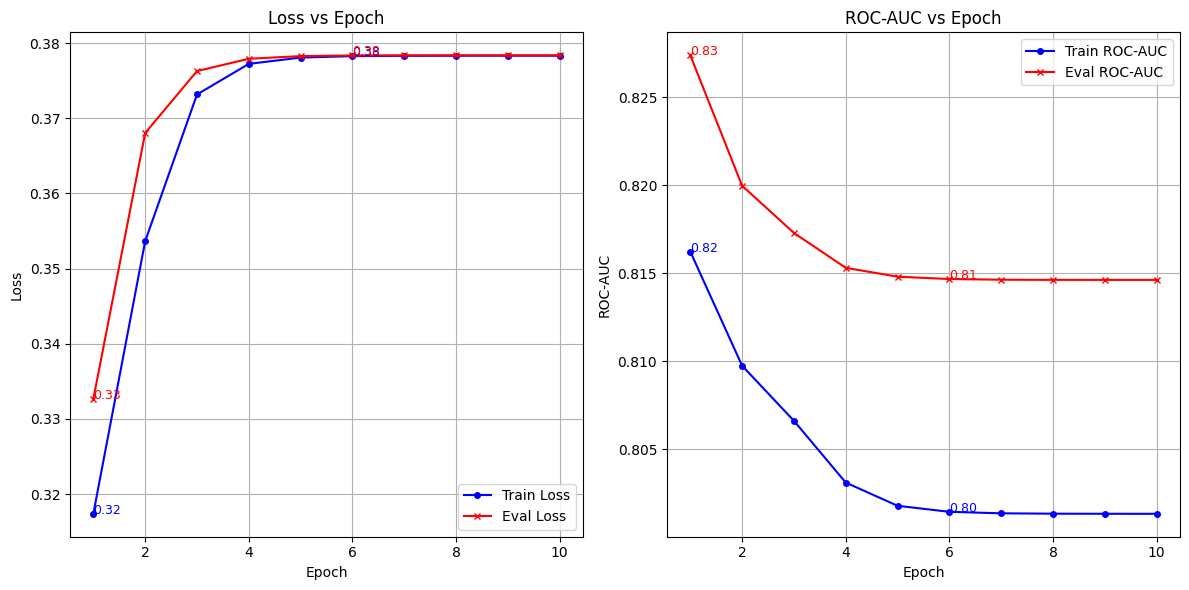

Training with config: Config(experiment_name='BaseModel', seed=42, batch_size=32, hidden_size=128, lr=0.01, num_epochs=10, weight_decay=0.01, drop_p=0)
cuda


 10%|█         | 1/10 [00:14<02:09, 14.44s/it]

Epoch 1/10: Train Loss=0.2955, Train ROC-AUC=0.8352, Eval Loss=0.2787, Eval ROC-AUC=0.8697


 20%|██        | 2/10 [00:28<01:53, 14.15s/it]

Epoch 2/10: Train Loss=0.2783, Train ROC-AUC=0.8618, Eval Loss=0.2699, Eval ROC-AUC=0.8856


 30%|███       | 3/10 [00:42<01:40, 14.35s/it]

Epoch 3/10: Train Loss=0.2712, Train ROC-AUC=0.8736, Eval Loss=0.2646, Eval ROC-AUC=0.8915


 40%|████      | 4/10 [00:57<01:27, 14.58s/it]

Epoch 4/10: Train Loss=0.2667, Train ROC-AUC=0.8801, Eval Loss=0.2607, Eval ROC-AUC=0.8947


 50%|█████     | 5/10 [01:12<01:13, 14.65s/it]

Epoch 5/10: Train Loss=0.2631, Train ROC-AUC=0.8844, Eval Loss=0.2570, Eval ROC-AUC=0.8973


 60%|██████    | 6/10 [01:28<00:59, 14.92s/it]

Epoch 6/10: Train Loss=0.2595, Train ROC-AUC=0.8879, Eval Loss=0.2528, Eval ROC-AUC=0.9000


 70%|███████   | 7/10 [01:43<00:44, 14.91s/it]

Epoch 7/10: Train Loss=0.2553, Train ROC-AUC=0.8912, Eval Loss=0.2476, Eval ROC-AUC=0.9029


 80%|████████  | 8/10 [01:57<00:29, 14.81s/it]

Epoch 8/10: Train Loss=0.2497, Train ROC-AUC=0.8945, Eval Loss=0.2402, Eval ROC-AUC=0.9069


 90%|█████████ | 9/10 [02:12<00:14, 14.82s/it]

Epoch 9/10: Train Loss=0.2409, Train ROC-AUC=0.8992, Eval Loss=0.2270, Eval ROC-AUC=0.9136


100%|██████████| 10/10 [02:27<00:00, 14.72s/it]

Epoch 10/10: Train Loss=0.2303, Train ROC-AUC=0.9047, Eval Loss=0.2202, Eval ROC-AUC=0.9168


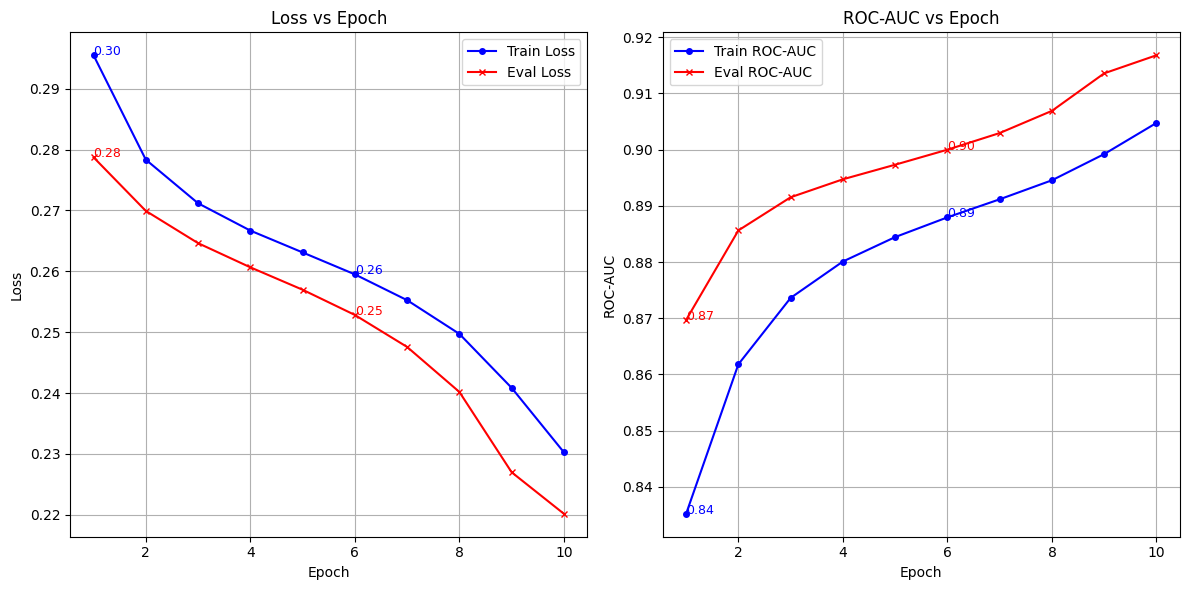

Training with config: Config(experiment_name='BaseModel', seed=42, batch_size=32, hidden_size=128, lr=0.01, num_epochs=10, weight_decay=0.001, drop_p=0)
cuda


 10%|█         | 1/10 [00:14<02:12, 14.73s/it]

Epoch 1/10: Train Loss=0.2935, Train ROC-AUC=0.8381, Eval Loss=0.2749, Eval ROC-AUC=0.8797


 20%|██        | 2/10 [00:29<01:57, 14.68s/it]

Epoch 2/10: Train Loss=0.2702, Train ROC-AUC=0.8711, Eval Loss=0.2620, Eval ROC-AUC=0.8950


 30%|███       | 3/10 [00:44<01:43, 14.76s/it]

Epoch 3/10: Train Loss=0.2574, Train ROC-AUC=0.8839, Eval Loss=0.2519, Eval ROC-AUC=0.8999


 40%|████      | 4/10 [00:58<01:28, 14.71s/it]

Epoch 4/10: Train Loss=0.2472, Train ROC-AUC=0.8917, Eval Loss=0.2443, Eval ROC-AUC=0.9040


 50%|█████     | 5/10 [01:13<01:13, 14.71s/it]

Epoch 5/10: Train Loss=0.2383, Train ROC-AUC=0.8979, Eval Loss=0.2393, Eval ROC-AUC=0.9074


 60%|██████    | 6/10 [01:28<00:58, 14.72s/it]

Epoch 6/10: Train Loss=0.2316, Train ROC-AUC=0.9025, Eval Loss=0.2367, Eval ROC-AUC=0.9093


 70%|███████   | 7/10 [01:43<00:44, 14.72s/it]

Epoch 7/10: Train Loss=0.2272, Train ROC-AUC=0.9056, Eval Loss=0.2346, Eval ROC-AUC=0.9108


 80%|████████  | 8/10 [01:57<00:29, 14.70s/it]

Epoch 8/10: Train Loss=0.2240, Train ROC-AUC=0.9078, Eval Loss=0.2323, Eval ROC-AUC=0.9120


 90%|█████████ | 9/10 [02:12<00:14, 14.73s/it]

Epoch 9/10: Train Loss=0.2215, Train ROC-AUC=0.9095, Eval Loss=0.2300, Eval ROC-AUC=0.9132


100%|██████████| 10/10 [02:26<00:00, 14.68s/it]

Epoch 10/10: Train Loss=0.2195, Train ROC-AUC=0.9109, Eval Loss=0.2280, Eval ROC-AUC=0.9138


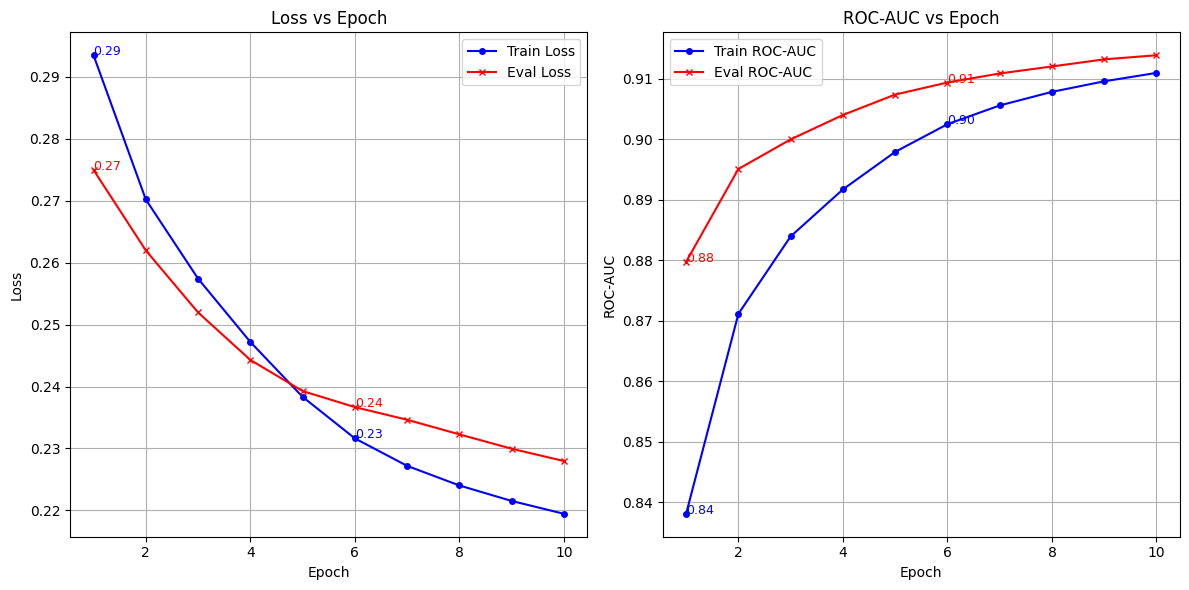

Training with config: Config(experiment_name='BaseModel', seed=42, batch_size=32, hidden_size=128, lr=0.05, num_epochs=10, weight_decay=0.1, drop_p=0)
cuda


 10%|█         | 1/10 [00:15<02:16, 15.12s/it]

Epoch 1/10: Train Loss=0.3615, Train ROC-AUC=0.7879, Eval Loss=0.3773, Eval ROC-AUC=0.8139


 20%|██        | 2/10 [00:31<02:04, 15.58s/it]

Epoch 2/10: Train Loss=0.3787, Train ROC-AUC=0.7941, Eval Loss=0.3774, Eval ROC-AUC=0.8137


 30%|███       | 3/10 [00:46<01:49, 15.70s/it]

Epoch 3/10: Train Loss=0.3787, Train ROC-AUC=0.7941, Eval Loss=0.3774, Eval ROC-AUC=0.8137


 40%|████      | 4/10 [01:02<01:34, 15.69s/it]

Epoch 4/10: Train Loss=0.3787, Train ROC-AUC=0.7941, Eval Loss=0.3774, Eval ROC-AUC=0.8137


 50%|█████     | 5/10 [01:18<01:18, 15.67s/it]

Epoch 5/10: Train Loss=0.3787, Train ROC-AUC=0.7941, Eval Loss=0.3774, Eval ROC-AUC=0.8137


 60%|██████    | 6/10 [01:33<01:02, 15.70s/it]

Epoch 6/10: Train Loss=0.3787, Train ROC-AUC=0.7941, Eval Loss=0.3774, Eval ROC-AUC=0.8137


 70%|███████   | 7/10 [01:49<00:47, 15.79s/it]

Epoch 7/10: Train Loss=0.3787, Train ROC-AUC=0.7941, Eval Loss=0.3774, Eval ROC-AUC=0.8137


 80%|████████  | 8/10 [02:05<00:31, 15.81s/it]

Epoch 8/10: Train Loss=0.3787, Train ROC-AUC=0.7941, Eval Loss=0.3774, Eval ROC-AUC=0.8137


 90%|█████████ | 9/10 [02:21<00:15, 15.82s/it]

Epoch 9/10: Train Loss=0.3787, Train ROC-AUC=0.7941, Eval Loss=0.3774, Eval ROC-AUC=0.8137


100%|██████████| 10/10 [02:37<00:00, 15.74s/it]

Epoch 10/10: Train Loss=0.3787, Train ROC-AUC=0.7941, Eval Loss=0.3774, Eval ROC-AUC=0.8137


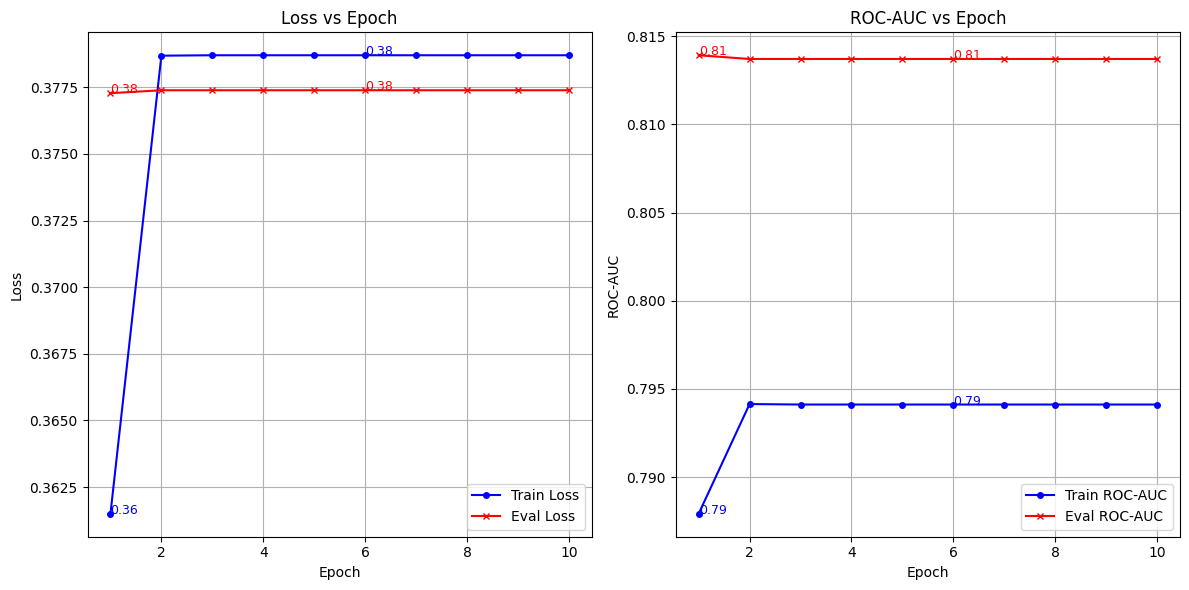

Training with config: Config(experiment_name='BaseModel', seed=42, batch_size=32, hidden_size=128, lr=0.05, num_epochs=10, weight_decay=0.01, drop_p=0)
cuda


 10%|█         | 1/10 [00:16<02:24, 16.01s/it]

Epoch 1/10: Train Loss=0.2902, Train ROC-AUC=0.8443, Eval Loss=0.2676, Eval ROC-AUC=0.8902


 20%|██        | 2/10 [00:31<02:07, 15.94s/it]

Epoch 2/10: Train Loss=0.2602, Train ROC-AUC=0.8844, Eval Loss=0.2393, Eval ROC-AUC=0.9082


 30%|███       | 3/10 [00:47<01:51, 15.91s/it]

Epoch 3/10: Train Loss=0.2365, Train ROC-AUC=0.8997, Eval Loss=0.2333, Eval ROC-AUC=0.9164


 40%|████      | 4/10 [01:03<01:35, 15.86s/it]

Epoch 4/10: Train Loss=0.2341, Train ROC-AUC=0.9010, Eval Loss=0.2391, Eval ROC-AUC=0.9105


 50%|█████     | 5/10 [01:19<01:19, 15.85s/it]

Epoch 5/10: Train Loss=0.2336, Train ROC-AUC=0.9016, Eval Loss=0.2428, Eval ROC-AUC=0.9035


 60%|██████    | 6/10 [01:35<01:03, 15.82s/it]

Epoch 6/10: Train Loss=0.2340, Train ROC-AUC=0.9015, Eval Loss=0.2427, Eval ROC-AUC=0.9016


 70%|███████   | 7/10 [01:50<00:46, 15.61s/it]

Epoch 7/10: Train Loss=0.2338, Train ROC-AUC=0.9014, Eval Loss=0.2408, Eval ROC-AUC=0.9017


 80%|████████  | 8/10 [02:04<00:30, 15.31s/it]

Epoch 8/10: Train Loss=0.2336, Train ROC-AUC=0.9013, Eval Loss=0.2376, Eval ROC-AUC=0.9027


 90%|█████████ | 9/10 [02:20<00:15, 15.45s/it]

Epoch 9/10: Train Loss=0.2333, Train ROC-AUC=0.9011, Eval Loss=0.2353, Eval ROC-AUC=0.9004


100%|██████████| 10/10 [02:36<00:00, 15.65s/it]

Epoch 10/10: Train Loss=0.2333, Train ROC-AUC=0.9006, Eval Loss=0.2329, Eval ROC-AUC=0.9035


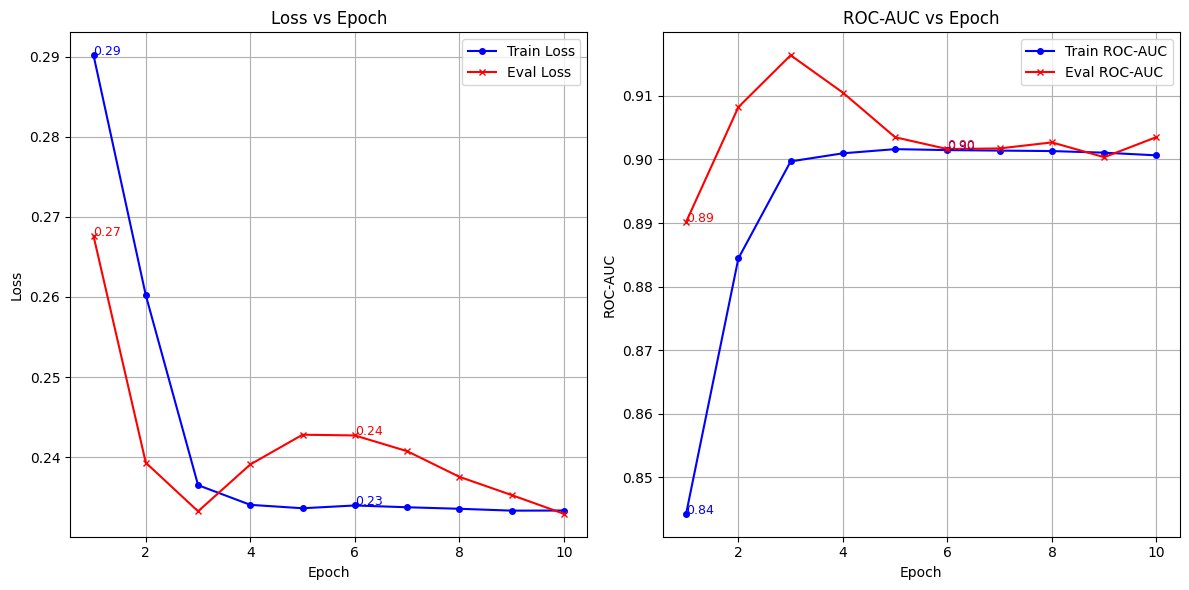

Training with config: Config(experiment_name='BaseModel', seed=42, batch_size=32, hidden_size=128, lr=0.05, num_epochs=10, weight_decay=0.001, drop_p=0)
cuda


 10%|█         | 1/10 [00:15<02:23, 15.89s/it]

Epoch 1/10: Train Loss=0.2918, Train ROC-AUC=0.8454, Eval Loss=0.2702, Eval ROC-AUC=0.8802


 20%|██        | 2/10 [00:31<02:06, 15.80s/it]

Epoch 2/10: Train Loss=0.2539, Train ROC-AUC=0.8852, Eval Loss=0.2522, Eval ROC-AUC=0.8966


 30%|███       | 3/10 [00:47<01:51, 15.87s/it]

Epoch 3/10: Train Loss=0.2346, Train ROC-AUC=0.8997, Eval Loss=0.2440, Eval ROC-AUC=0.9037


 40%|████      | 4/10 [01:03<01:35, 15.84s/it]

Epoch 4/10: Train Loss=0.2245, Train ROC-AUC=0.9063, Eval Loss=0.2352, Eval ROC-AUC=0.9088


 50%|█████     | 5/10 [01:19<01:19, 15.85s/it]

Epoch 5/10: Train Loss=0.2186, Train ROC-AUC=0.9100, Eval Loss=0.2280, Eval ROC-AUC=0.9123


 60%|██████    | 6/10 [01:35<01:03, 15.86s/it]

Epoch 6/10: Train Loss=0.2147, Train ROC-AUC=0.9124, Eval Loss=0.2223, Eval ROC-AUC=0.9148


 70%|███████   | 7/10 [01:50<00:47, 15.85s/it]

Epoch 7/10: Train Loss=0.2119, Train ROC-AUC=0.9141, Eval Loss=0.2169, Eval ROC-AUC=0.9171


 80%|████████  | 8/10 [02:06<00:31, 15.76s/it]

Epoch 8/10: Train Loss=0.2098, Train ROC-AUC=0.9155, Eval Loss=0.2125, Eval ROC-AUC=0.9192


 90%|█████████ | 9/10 [02:22<00:15, 15.80s/it]

Epoch 9/10: Train Loss=0.2080, Train ROC-AUC=0.9168, Eval Loss=0.2099, Eval ROC-AUC=0.9205


100%|██████████| 10/10 [02:38<00:00, 15.81s/it]

Epoch 10/10: Train Loss=0.2065, Train ROC-AUC=0.9178, Eval Loss=0.2073, Eval ROC-AUC=0.9217


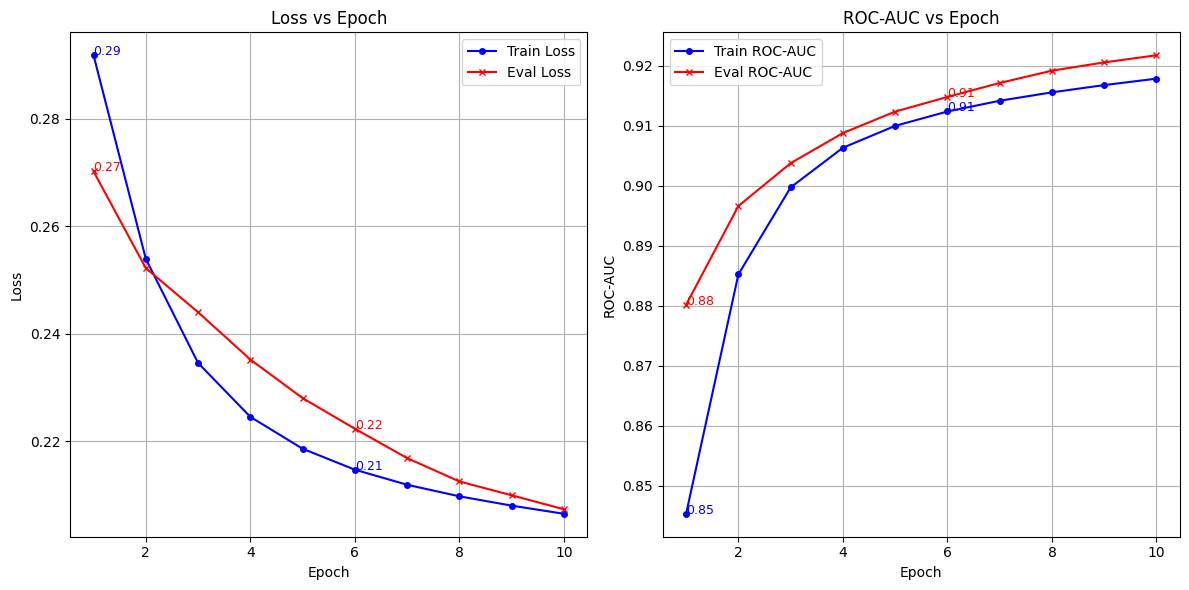

Training with config: Config(experiment_name='BaseModel', seed=42, batch_size=32, hidden_size=128, lr=0.1, num_epochs=10, weight_decay=0.1, drop_p=0)
cuda


 10%|█         | 1/10 [00:15<02:21, 15.77s/it]

Epoch 1/10: Train Loss=0.3728, Train ROC-AUC=0.7813, Eval Loss=0.3755, Eval ROC-AUC=0.8141


 20%|██        | 2/10 [00:30<02:00, 15.08s/it]

Epoch 2/10: Train Loss=0.3791, Train ROC-AUC=0.7873, Eval Loss=0.3755, Eval ROC-AUC=0.8141


 30%|███       | 3/10 [00:44<01:43, 14.85s/it]

Epoch 3/10: Train Loss=0.3791, Train ROC-AUC=0.7873, Eval Loss=0.3755, Eval ROC-AUC=0.8141


 40%|████      | 4/10 [00:59<01:29, 14.85s/it]

Epoch 4/10: Train Loss=0.3791, Train ROC-AUC=0.7873, Eval Loss=0.3755, Eval ROC-AUC=0.8141


 50%|█████     | 5/10 [01:13<01:12, 14.58s/it]

Epoch 5/10: Train Loss=0.3791, Train ROC-AUC=0.7873, Eval Loss=0.3755, Eval ROC-AUC=0.8141


 60%|██████    | 6/10 [01:28<00:58, 14.56s/it]

Epoch 6/10: Train Loss=0.3791, Train ROC-AUC=0.7873, Eval Loss=0.3755, Eval ROC-AUC=0.8141


 70%|███████   | 7/10 [01:43<00:43, 14.59s/it]

Epoch 7/10: Train Loss=0.3791, Train ROC-AUC=0.7873, Eval Loss=0.3755, Eval ROC-AUC=0.8141


 80%|████████  | 8/10 [01:57<00:29, 14.66s/it]

Epoch 8/10: Train Loss=0.3791, Train ROC-AUC=0.7873, Eval Loss=0.3755, Eval ROC-AUC=0.8141


 90%|█████████ | 9/10 [02:12<00:14, 14.69s/it]

Epoch 9/10: Train Loss=0.3791, Train ROC-AUC=0.7873, Eval Loss=0.3755, Eval ROC-AUC=0.8141


100%|██████████| 10/10 [02:27<00:00, 14.74s/it]

Epoch 10/10: Train Loss=0.3791, Train ROC-AUC=0.7873, Eval Loss=0.3755, Eval ROC-AUC=0.8141


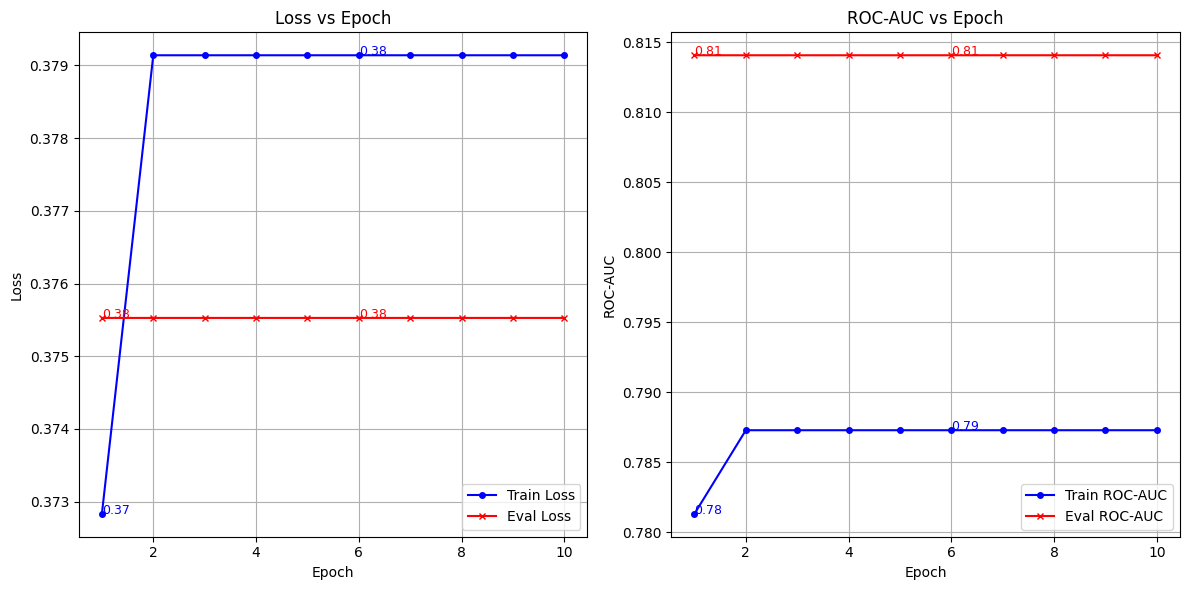

Training with config: Config(experiment_name='BaseModel', seed=42, batch_size=32, hidden_size=128, lr=0.1, num_epochs=10, weight_decay=0.01, drop_p=0)
cuda


 10%|█         | 1/10 [00:14<02:11, 14.61s/it]

Epoch 1/10: Train Loss=0.2892, Train ROC-AUC=0.8483, Eval Loss=0.2546, Eval ROC-AUC=0.9008


 20%|██        | 2/10 [00:29<01:56, 14.60s/it]

Epoch 2/10: Train Loss=0.2446, Train ROC-AUC=0.8935, Eval Loss=0.2564, Eval ROC-AUC=0.8985


 30%|███       | 3/10 [00:43<01:41, 14.56s/it]

Epoch 3/10: Train Loss=0.2421, Train ROC-AUC=0.8951, Eval Loss=0.2631, Eval ROC-AUC=0.8875


 40%|████      | 4/10 [00:58<01:27, 14.62s/it]

Epoch 4/10: Train Loss=0.2419, Train ROC-AUC=0.8952, Eval Loss=0.2617, Eval ROC-AUC=0.8880


 50%|█████     | 5/10 [01:13<01:13, 14.61s/it]

Epoch 5/10: Train Loss=0.2419, Train ROC-AUC=0.8950, Eval Loss=0.2566, Eval ROC-AUC=0.8929


 60%|██████    | 6/10 [01:27<00:58, 14.64s/it]

Epoch 6/10: Train Loss=0.2415, Train ROC-AUC=0.8950, Eval Loss=0.2552, Eval ROC-AUC=0.8930


 70%|███████   | 7/10 [01:42<00:44, 14.70s/it]

Epoch 7/10: Train Loss=0.2415, Train ROC-AUC=0.8951, Eval Loss=0.2577, Eval ROC-AUC=0.8921


 80%|████████  | 8/10 [01:57<00:29, 14.68s/it]

Epoch 8/10: Train Loss=0.2417, Train ROC-AUC=0.8947, Eval Loss=0.2566, Eval ROC-AUC=0.8937


 90%|█████████ | 9/10 [02:11<00:14, 14.65s/it]

Epoch 9/10: Train Loss=0.2417, Train ROC-AUC=0.8948, Eval Loss=0.2568, Eval ROC-AUC=0.8932


100%|██████████| 10/10 [02:26<00:00, 14.64s/it]

Epoch 10/10: Train Loss=0.2418, Train ROC-AUC=0.8950, Eval Loss=0.2574, Eval ROC-AUC=0.8931


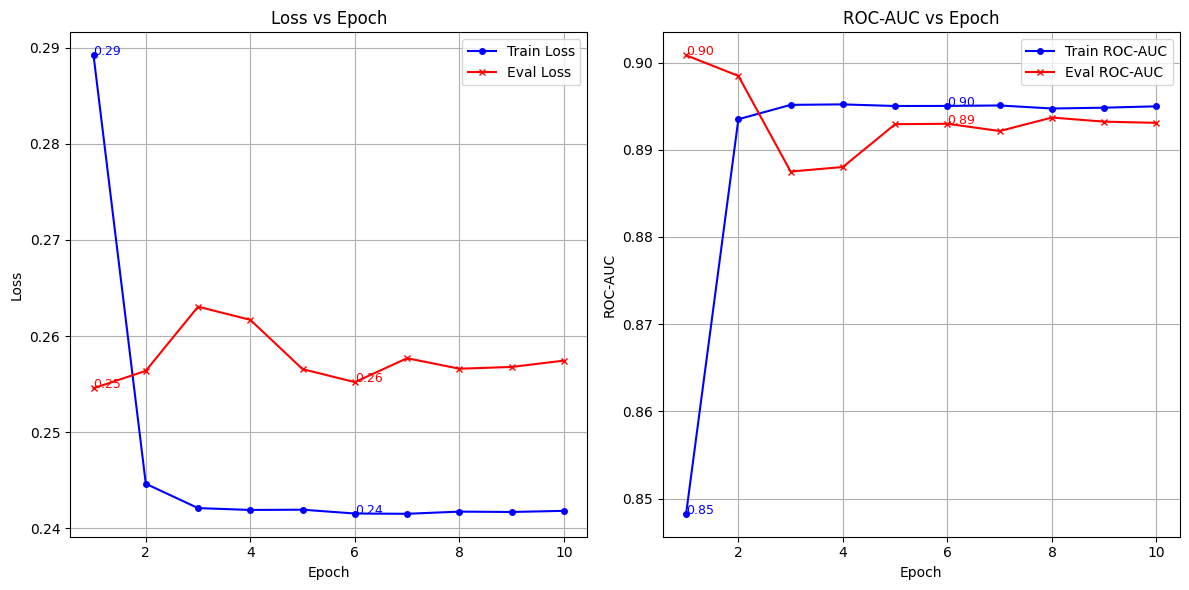

Training with config: Config(experiment_name='BaseModel', seed=42, batch_size=32, hidden_size=128, lr=0.1, num_epochs=10, weight_decay=0.001, drop_p=0)
cuda


 10%|█         | 1/10 [00:14<02:11, 14.64s/it]

Epoch 1/10: Train Loss=0.2944, Train ROC-AUC=0.8455, Eval Loss=0.2658, Eval ROC-AUC=0.8806


 20%|██        | 2/10 [00:29<01:56, 14.61s/it]

Epoch 2/10: Train Loss=0.2433, Train ROC-AUC=0.8930, Eval Loss=0.2482, Eval ROC-AUC=0.8970


 30%|███       | 3/10 [00:43<01:42, 14.63s/it]

Epoch 3/10: Train Loss=0.2257, Train ROC-AUC=0.9048, Eval Loss=0.2345, Eval ROC-AUC=0.9058


 40%|████      | 4/10 [00:57<01:25, 14.29s/it]

Epoch 4/10: Train Loss=0.2189, Train ROC-AUC=0.9090, Eval Loss=0.2253, Eval ROC-AUC=0.9116


 50%|█████     | 5/10 [01:12<01:11, 14.33s/it]

Epoch 5/10: Train Loss=0.2150, Train ROC-AUC=0.9115, Eval Loss=0.2194, Eval ROC-AUC=0.9155


 60%|██████    | 6/10 [01:26<00:57, 14.39s/it]

Epoch 6/10: Train Loss=0.2123, Train ROC-AUC=0.9134, Eval Loss=0.2155, Eval ROC-AUC=0.9179


 70%|███████   | 7/10 [01:41<00:43, 14.56s/it]

Epoch 7/10: Train Loss=0.2102, Train ROC-AUC=0.9149, Eval Loss=0.2124, Eval ROC-AUC=0.9199


 80%|████████  | 8/10 [01:56<00:29, 14.56s/it]

Epoch 8/10: Train Loss=0.2087, Train ROC-AUC=0.9161, Eval Loss=0.2103, Eval ROC-AUC=0.9212


 90%|█████████ | 9/10 [02:10<00:14, 14.67s/it]

Epoch 9/10: Train Loss=0.2075, Train ROC-AUC=0.9170, Eval Loss=0.2090, Eval ROC-AUC=0.9222


100%|██████████| 10/10 [02:25<00:00, 14.58s/it]

Epoch 10/10: Train Loss=0.2067, Train ROC-AUC=0.9176, Eval Loss=0.2076, Eval ROC-AUC=0.9229


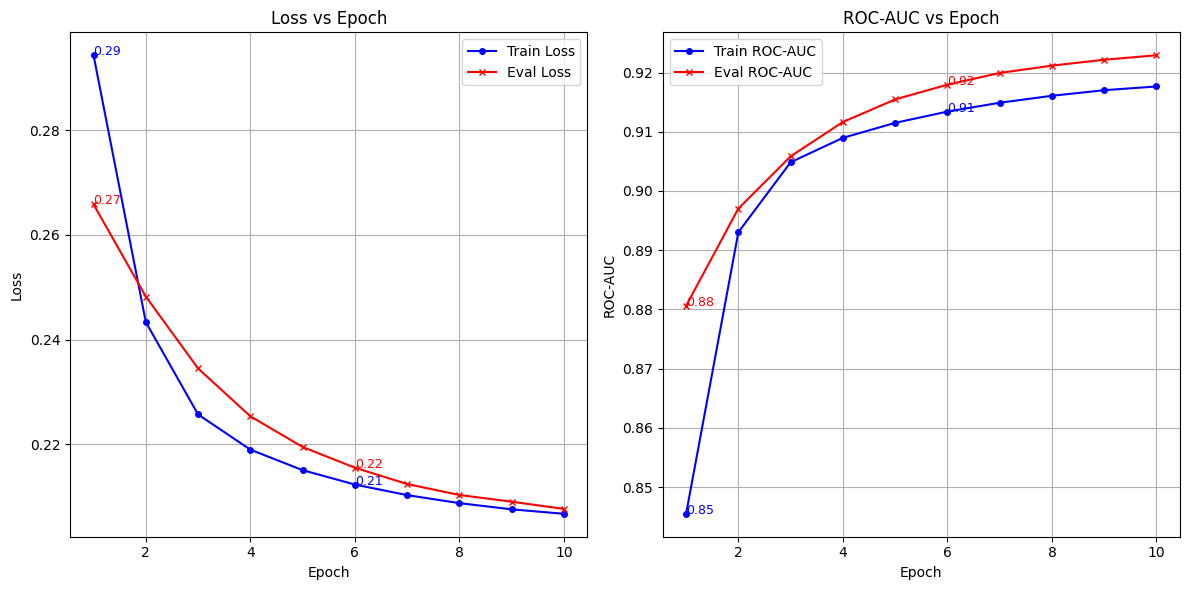

In [84]:
weight_lr_config = Config(experiment_name='WeightLr',
                         batch_size=32, 
                         hidden_size=128, 
                         num_epochs=10, 
                         drop_p=0,
                         lr=0.01, 
                         seed=42)
learning_rates = [0.01, 0.05, 0.1]
weight_decay_values = [0.1, 0.01, 0.001]
for lr, wd in product(learning_rates, weight_decay_values):
    weight_lr_config.lr = lr
    weight_lr_config.weight_decay = wd
    print(f'Training with config: {weight_lr_config}')
    train(weight_lr_config, DropoutModel, train_dataset, test_dataset)